Regenerate key plots with corrected methodology:
- Use token IDs instead of representation matching
- Switch to probability/likelihood metrics
- Analyze first generated token

Create comparison analyses:

- Correct vs incorrect within each language
- English answer probabilities during non-English generation
- Filter for culturally-distinct QA pairs

Statistical validation:

- Calculate random baseline (Monte Carlo simulation)
- Add confidence intervals and significance tests
- Implement Mann-Whitney U tests and Cohen's d

Additional language validation:

- Alvin to analyze Chinese/Cantonese data
- Verify patterns hold across more languages

For Istiak:

1. Filter out cases where Bengali correct answer matches English correct answer (focus on 314 cases where answers differ)
2. Calculate random baseline (Monte Carlo simulation) for accuracy evaluation
3. Track log likelihood for English ground truth answers when prompting in Bengali (compare when model is correct vs incorrect)
4. Regenerate proportion plots using token IDs instead of token representations for more reliable matching
5. Look at KL divergence from final distribution (not just layer-to-layer)
6. Consider entropy measurements as alternative to KL divergence for confidence
7. Normalize cosine similarity by comparing cross-language similarity to within-language similarity
8. Run experiments filtering for cases where model gets wrong answer due to cultural context (not lucky English matches)

In [1]:
ROOT_DIR = "indeterminant"
PREFIX = "predictions-"
LANGUAGES = [
    "bengali",
    "english",
    "spanish",
    "assamese"
]

OUTPUT_FOLDER = "figures"

LAYER_COUNT = 32
FINAL_LAYER = 32

FIGURE_WIDTH = 8
FIGURE_HEIGHT = 6
FIGURE_DPI = 300

CONFIDENCE_LEVEL = 0.95

SAVE_PLOTS = True
PLOT_FORMAT = "pdf"

class State:
    CORRECT = "correct"
    INCORRECT = "incorrect"
    UNDETERMINED = "undetermined"
    
    @classmethod
    def all(cls):
        return [cls.CORRECT, cls.INCORRECT, cls.UNDETERMINED]

print("Configuration loaded.")

Configuration loaded.


In [2]:
import os
import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from bnunicodenormalizer import Normalizer 
import unicodedata

sns.set_theme(
    style="darkgrid",
    rc={"figure.figsize": (FIGURE_WIDTH, FIGURE_HEIGHT), "figure.dpi": FIGURE_DPI},
    context="notebook"
)
bnorm=Normalizer()

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Basis Statistics

In [3]:
def load_language_data(language: str, translated: bool) -> pd.DataFrame:
    if translated:
        lang_path = f"indeterminant/predictions-{language}-generated-translated.jsonl"
    else:
        lang_path = f"indeterminant/predictions-{language}-generated.jsonl"
    
    df_lang = pd.read_json(lang_path, lines=True)    
    df_lang.set_index("Idx", inplace=True)
    
    return df_lang

def load_lens_data(language: str) -> pd.DataFrame:
    lens_path = f"indeterminant/predictions-{language}-lens.jsonl"
    df = pd.read_json(lens_path, lines=True)
    df.set_index("Id", inplace=True)
    return df

def normalize_answer(answer: str, language: str) -> str:
    if language == "bengali":
        words = answer.split()
        normalized_words = []
        for word in words:
            if not word.strip():
                continue
            normalized = bnorm(word)["normalized"]
            if normalized is None:
                continue
            normalized_words.append(normalized)        
        return " ".join(normalized_words)
        
    elif language == "assamese":
        return unicodedata.normalize('NFC', answer)
    return answer.lower().strip()

def check_answer_match(generated: str, answer_list: List[str], language: str) -> bool:
    if not generated or not answer_list:
        return False
    
    gen_norm = normalize_answer(generated, language)
    
    for ans in answer_list:
        ans_norm = normalize_answer(ans, language)
        if gen_norm in ans_norm or ans_norm in gen_norm:
            return True
    
    return False

def clean_generated_answer(generated: str) -> str:
    """Clean generated answer by removing prefixes and formatting"""
    if not generated:
        return ""
    generated = generated.strip().lower()
    if "," in generated:
        generated = generated.split(",")[0].strip()
    generated = re.sub(r'^\d+\.\s*', '', generated)    
    return generated.strip()

def classify_answer_english(row: pd.Series) -> str:
    generated = row.get("Generated", "")
    cleaned_generated = clean_generated_answer(generated)
    
    eng_answers = row.get("Answer", [])
    
    matches = check_answer_match(cleaned_generated, eng_answers, "english")
    
    return State.CORRECT if matches else State.INCORRECT

def classify_answer(row: pd.Series, eng_answers: list[str], language: str) -> str:
    """    
    Logic:
    1. If generated doesn't match language aznswers -> INCORRECT
    2. If generated matches language answers AND English answers -> UNDETERMINED
    3. If generated matches language answers but NOT English answers -> CORRECT
    """
    generated = row.get("CleanedAnswer", "")
    lang_answers = row.get("Answer", [])
    matches_lang = check_answer_match(generated, lang_answers, language)
    
    if not matches_lang:
        return State.INCORRECT
    
    translated = row.get("TranslatedAnswer", "")
    matches_eng = check_answer_match(translated, eng_answers, "english")
    
    if matches_eng:
        return State.UNDETERMINED

    return State.CORRECT

def analyze_english_correctness() -> pd.DataFrame:
    df_eng = load_language_data("english", translated=False)
    
    df_eng["State"] = df_eng.apply(classify_answer_english, axis=1)
    
    return df_eng

def analyze_language_correctness(language: str) -> pd.DataFrame:
    df_lang = load_language_data(language, translated=True)
    df_eng = load_language_data("english", translated=False)

    df_lang["State"] = df_lang.apply(
        lambda row: classify_answer(
            row, 
            df_eng.loc[row.name, "Answer"] if row.name in df_eng.index else [],
            language
        ),
        axis=1
    )
    
    return df_lang

def compute_statistics(languages: List[str]) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """Compute statistics for all languages."""
    stats_data = []
    modified_dfs = {}

    for lang in languages:
        if lang == "english":
            df = analyze_english_correctness()
        else:
            df = analyze_language_correctness(lang)
        
        total = len(df)
        correct = (df["State"] == State.CORRECT).sum()
        incorrect = (df["State"] == State.INCORRECT).sum()
        undetermined = (df["State"] == State.UNDETERMINED).sum()
        
        modified_dfs[lang] = df

        stats_data.append({
            "Language": lang,
            "Total": total,
            "Correct": correct,
            "Incorrect": incorrect,
            "Undetermined": undetermined,
            "Correct %": (correct / total * 100) if total > 0 else 0,
            "Incorrect %": (incorrect / total * 100) if total > 0 else 0,
            "Undetermined %": (undetermined / total * 100) if total > 0 else 0
        })
    
    return pd.DataFrame(stats_data), modified_dfs

In [4]:
stats_df, modified_dfs = compute_statistics(LANGUAGES)

print("Answer Correctness Statistics:")
print(stats_df.to_string(index=False))


Answer Correctness Statistics:
Language  Total  Correct  Incorrect  Undetermined  Correct %  Incorrect %  Undetermined %
 bengali    409       60        275            74  14.669927    67.237164       18.092910
 english    409      237        172             0  57.946210    42.053790        0.000000
 spanish    409       46        248           115  11.246944    60.635697       28.117359
assamese    409       55        311            43  13.447433    76.039120       10.513447


# Loglikelihood Analysis

Plotting log-likelihood trajectories...

Processing bengali...
Saved plot: figures/loglikelihood_trajectory_bengali.pdf


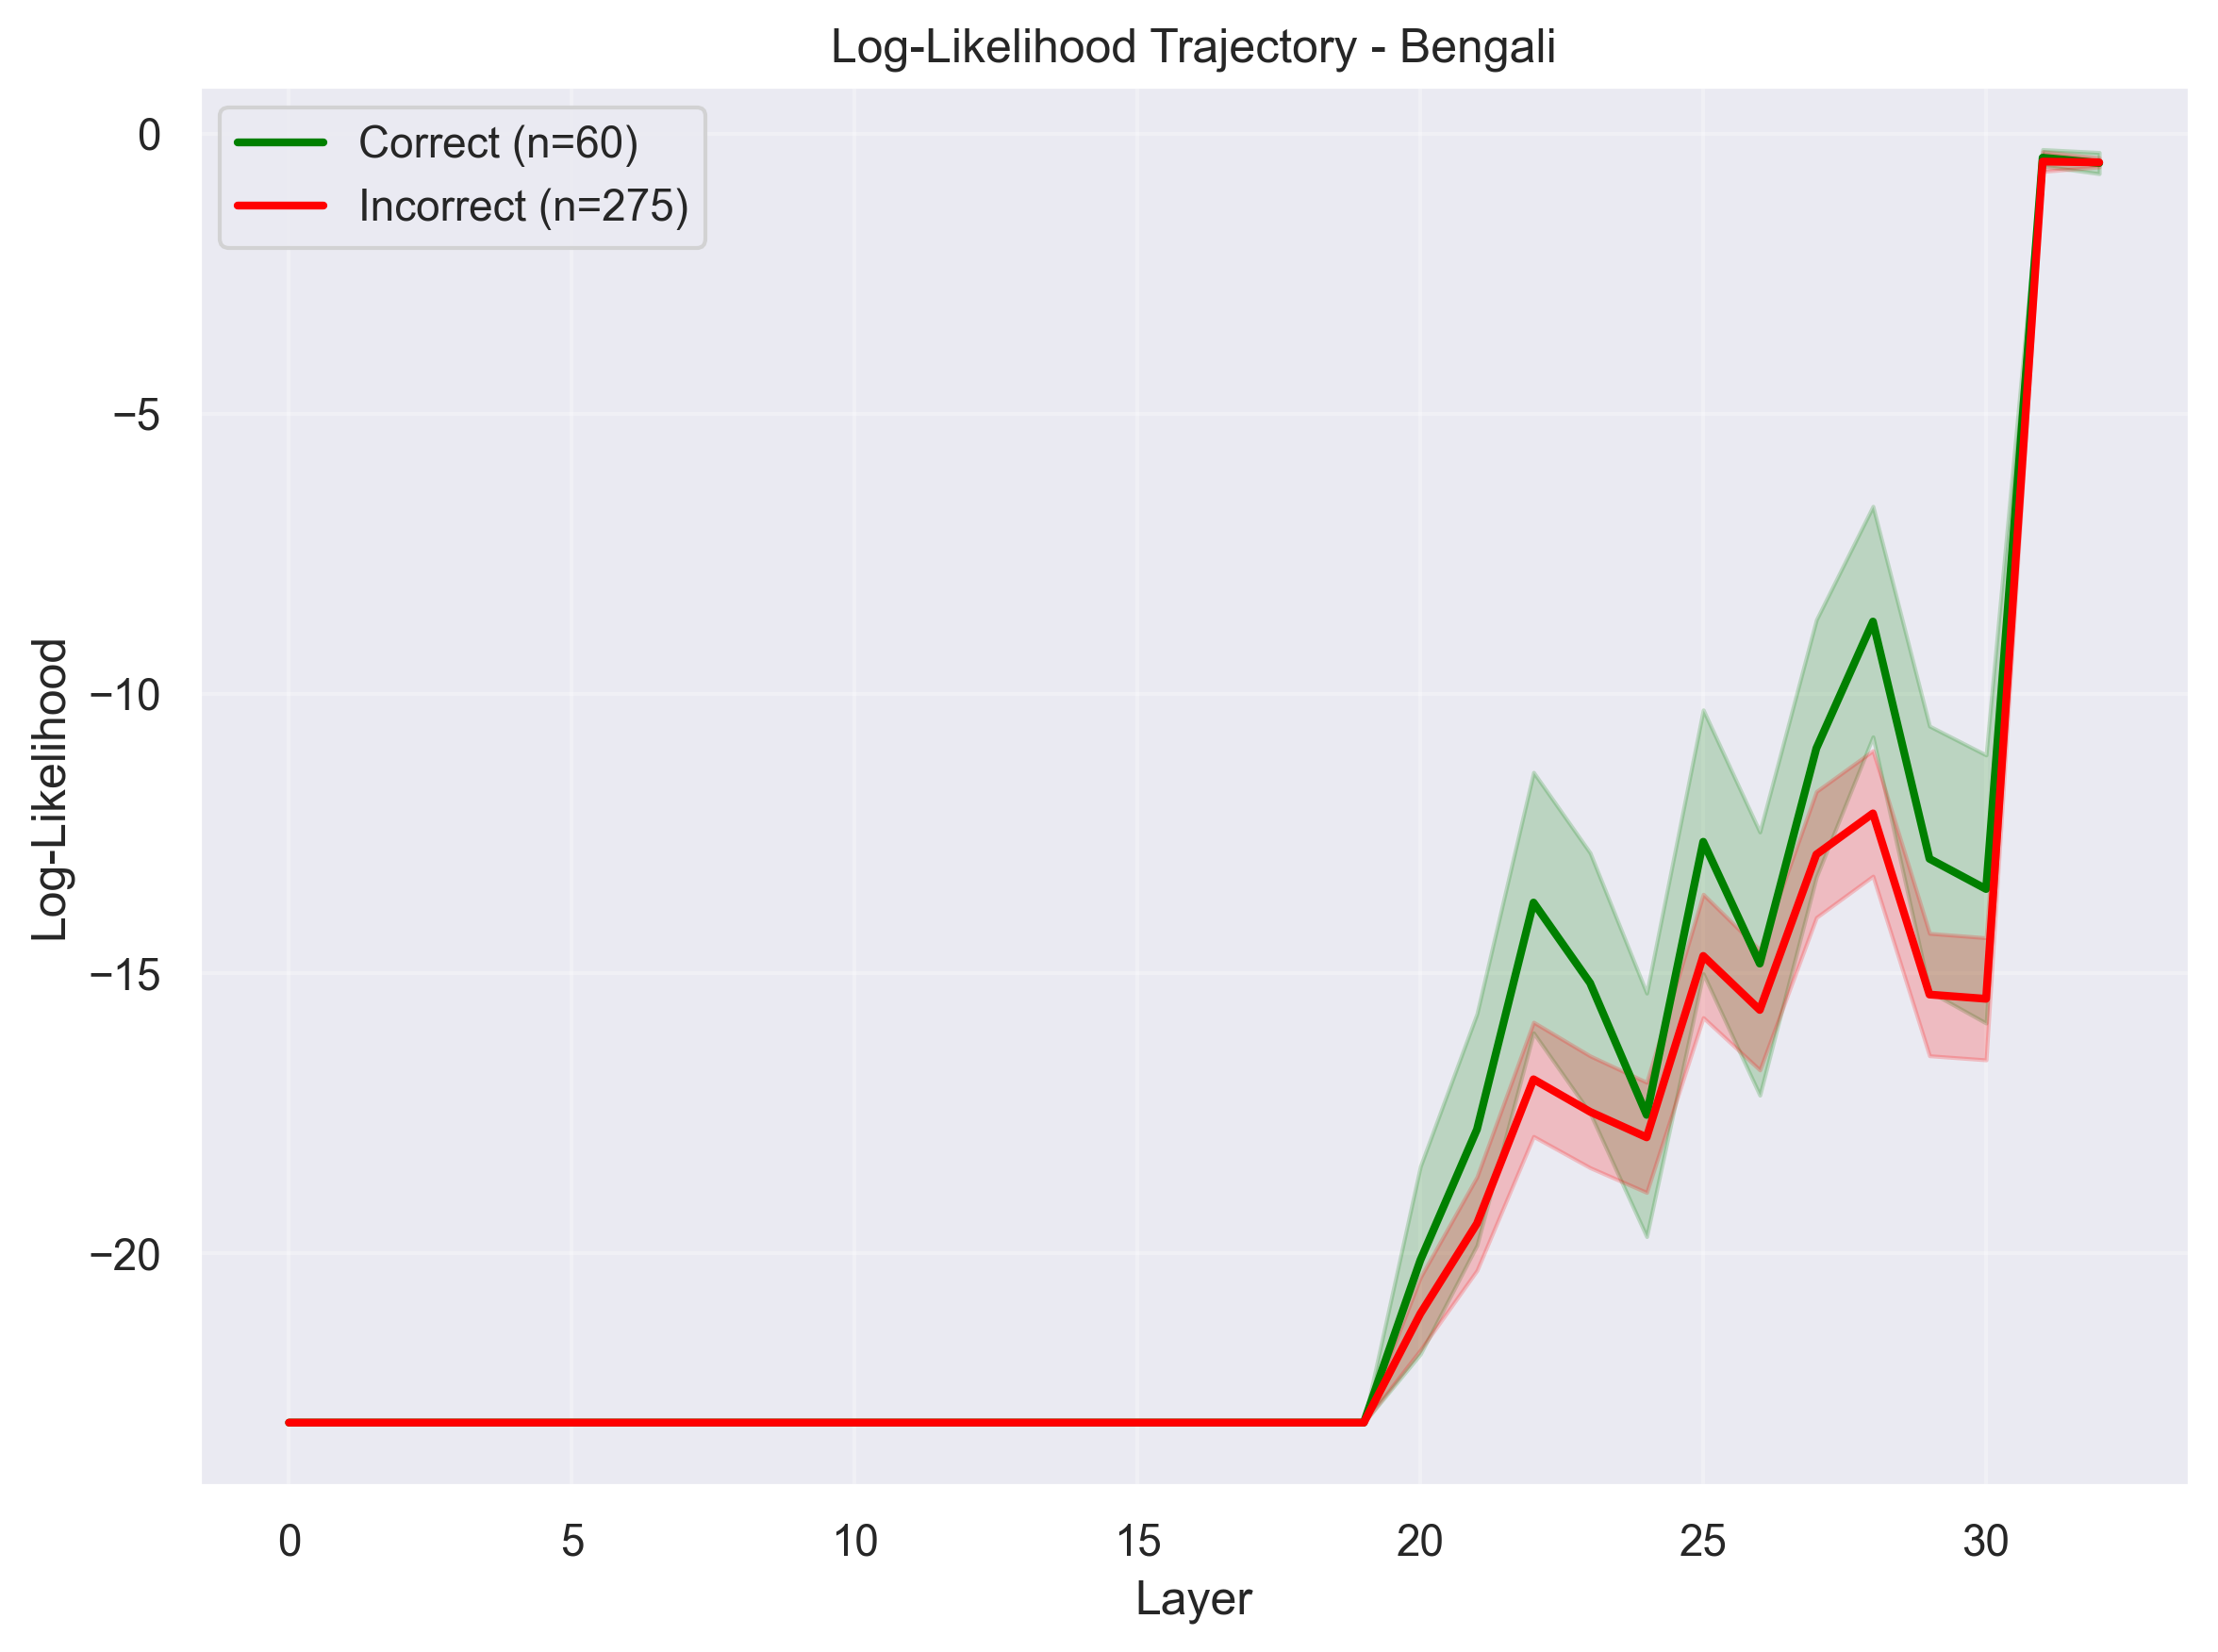

Processing english...
Saved plot: figures/loglikelihood_trajectory_english.pdf


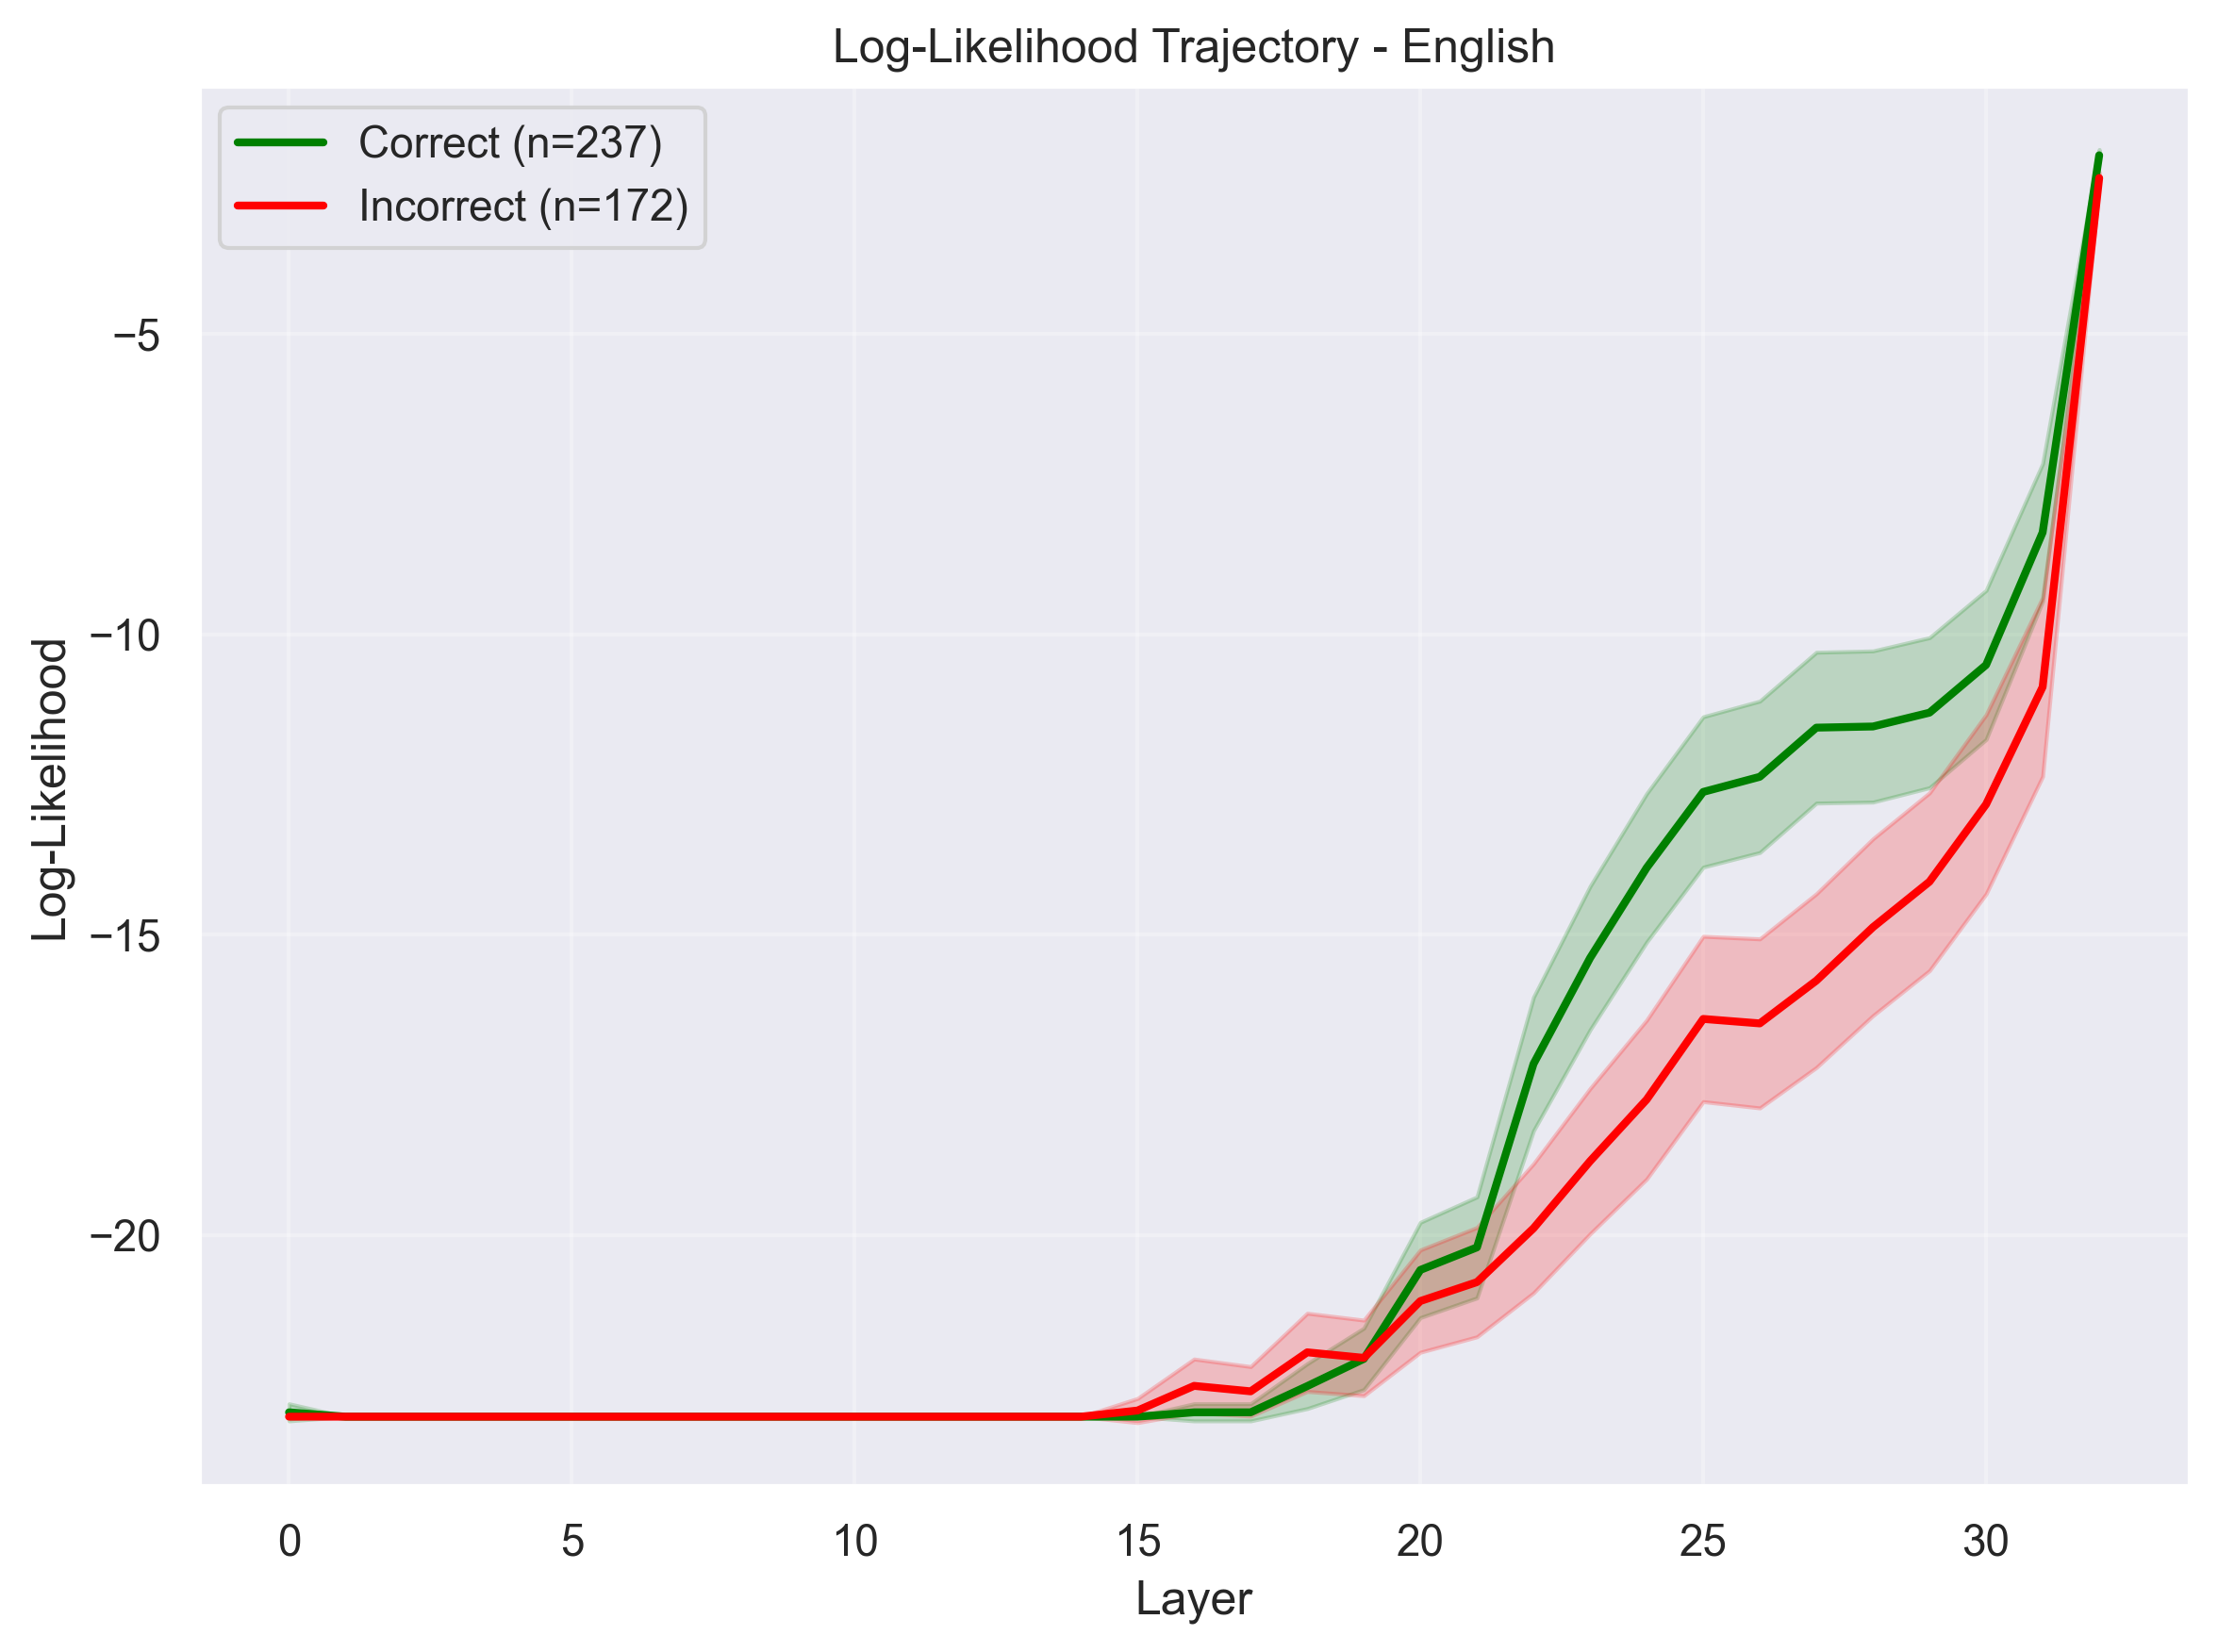

Processing spanish...
Saved plot: figures/loglikelihood_trajectory_spanish.pdf


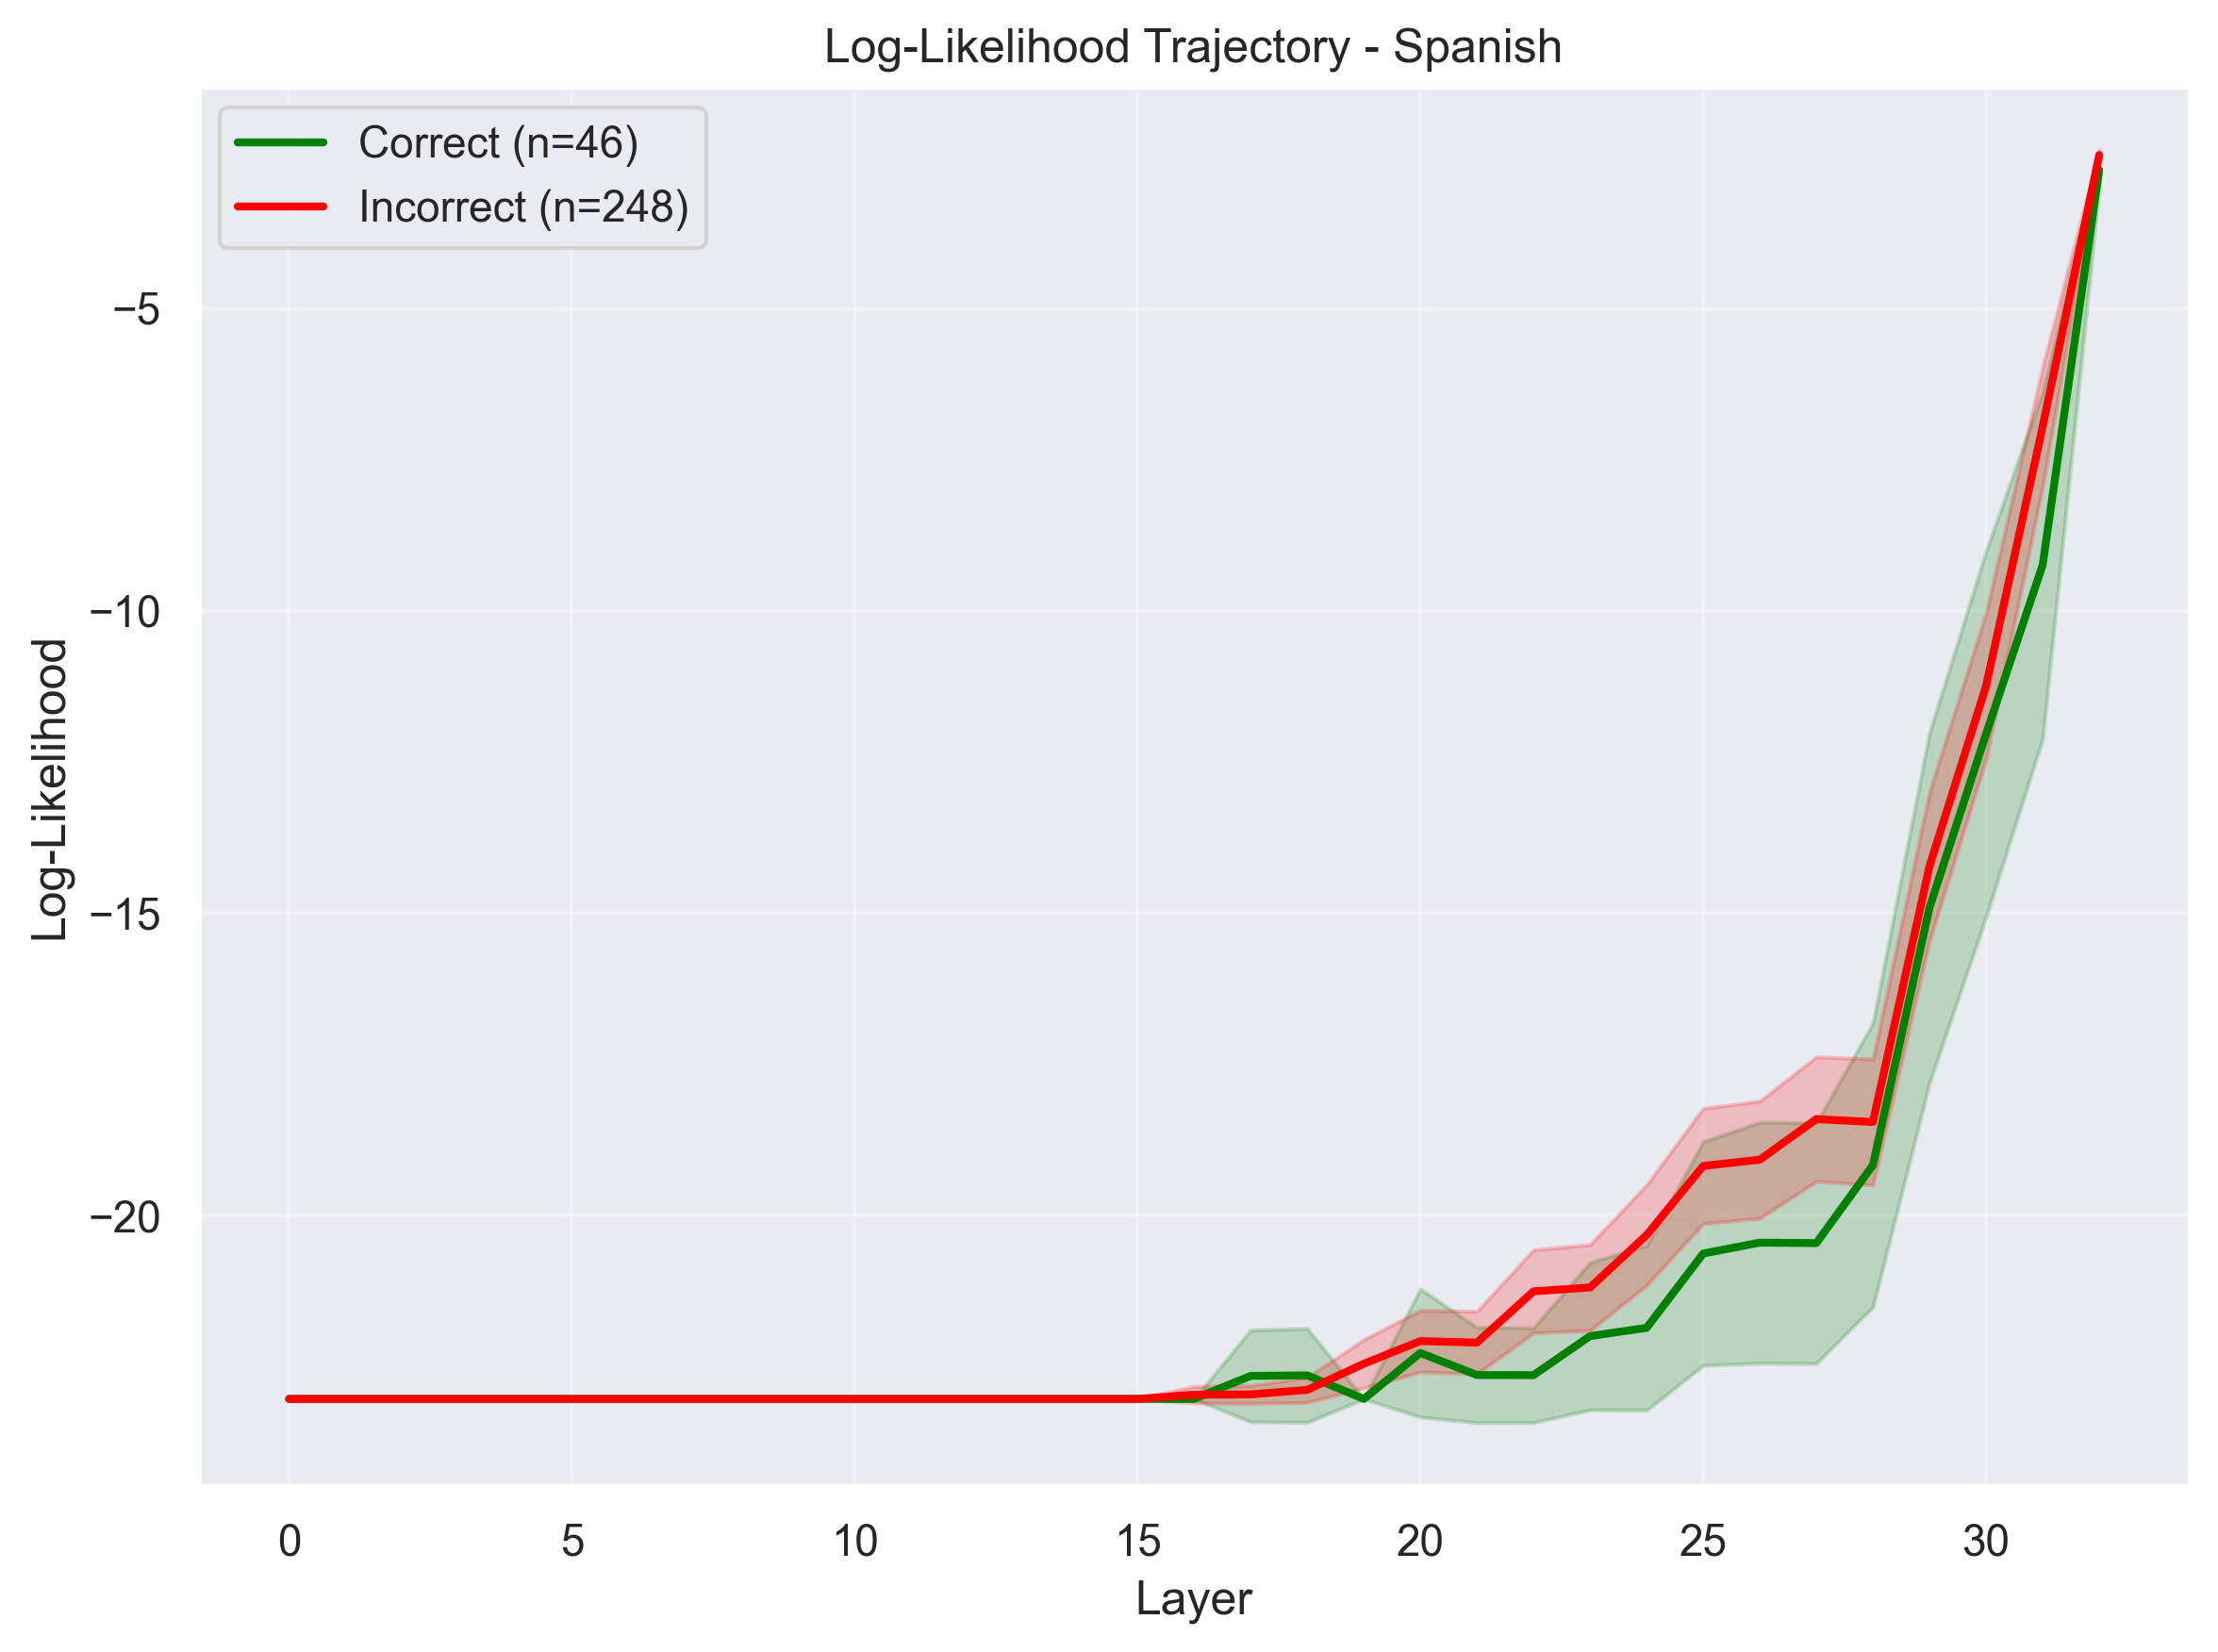

Processing assamese...
Saved plot: figures/loglikelihood_trajectory_assamese.pdf


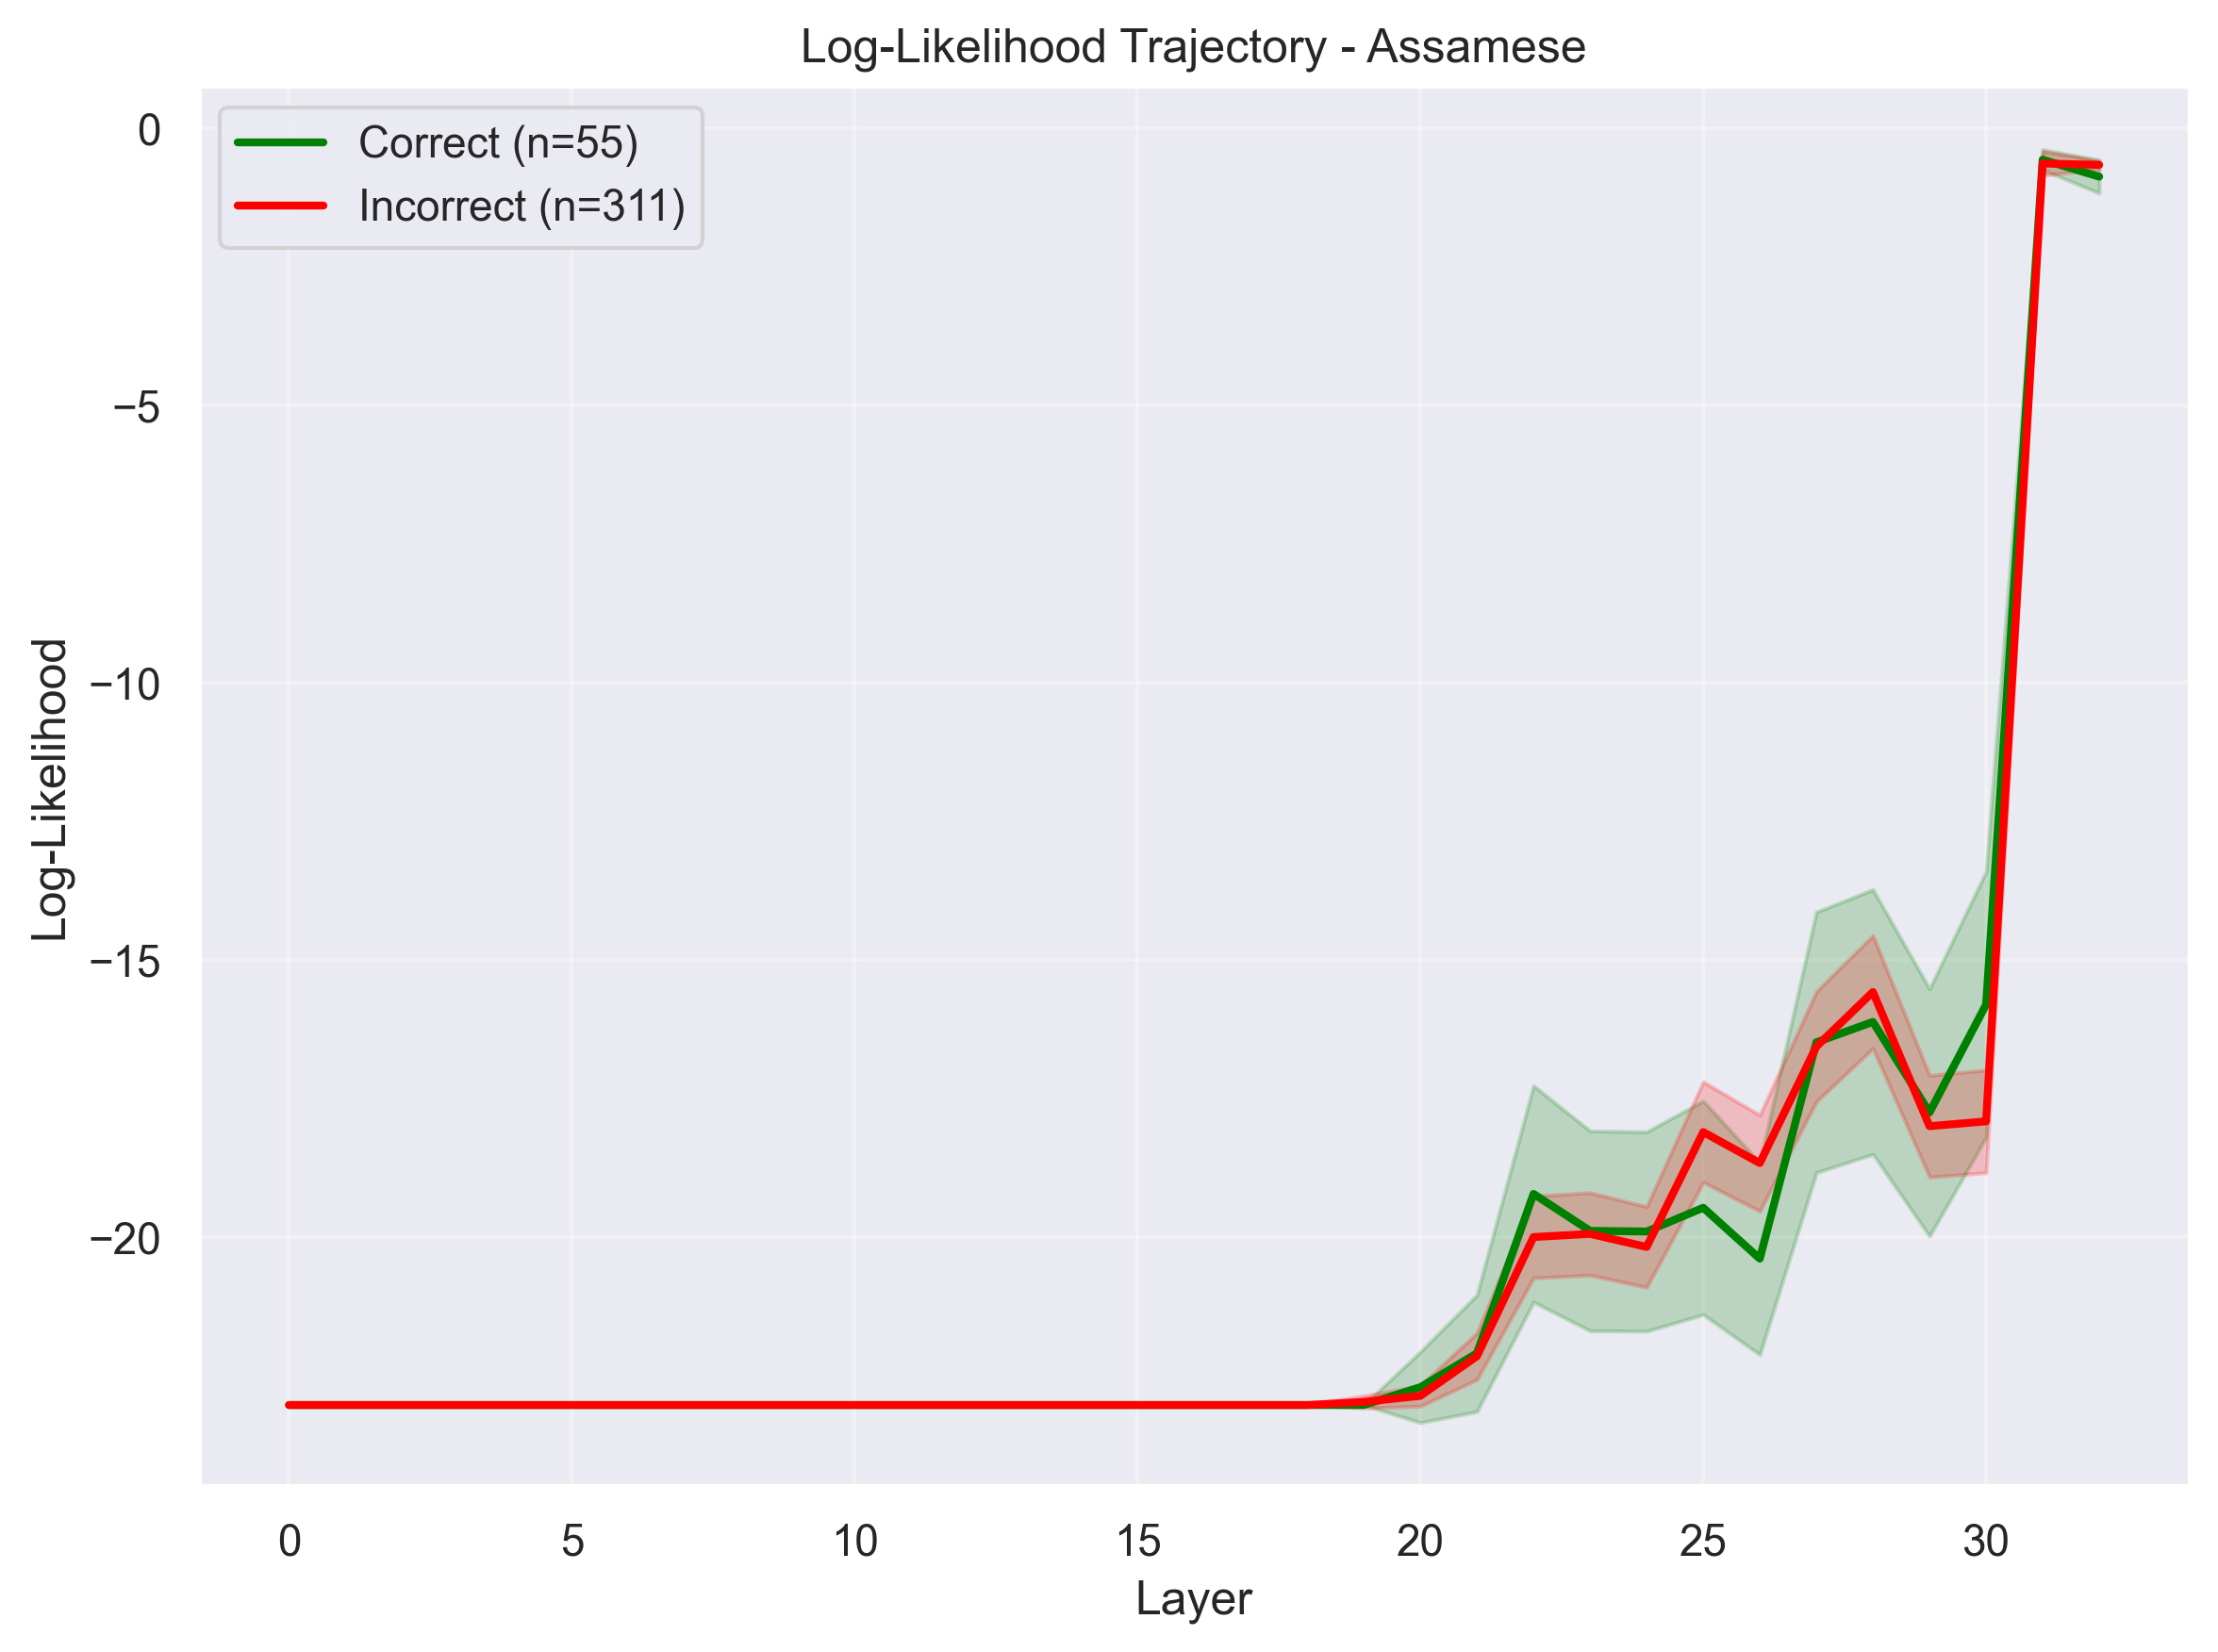

In [6]:
def get_token_logprob_trajectory(logit_lens_data: List[Dict], target_token_id: int) -> np.ndarray:
    trajectory = []
    for layer_data in logit_lens_data:
        layer_num = layer_data.get("layer")
        predictions = layer_data.get("predictions", [])        
        token_prob = None
        for pred in predictions:
            if pred.get("token_id") == target_token_id:
                token_prob = pred.get("confidence")
                break        
        if token_prob is None:
            token_prob = 1e-10
        log_prob = np.log(token_prob) if token_prob > 0 else np.log(1e-10)
        trajectory.append(log_prob)
    
    return np.array(trajectory)

def extract_final_token_id(logit_lens_data: List[Dict]) -> Optional[int]:
    if not logit_lens_data or len(logit_lens_data) == 0:
        return None
    
    final_layer = logit_lens_data[-1]  # Last layer
    if not final_layer.get("predictions"):
        return None
    
    predictions = final_layer["predictions"]
    
    # Iterate through predictions to find first non-empty token
    for prediction in predictions:
        token_id = prediction.get("token_id")
        token_str = prediction.get("token", "")
        
        # Skip if token is empty or just whitespace
        if token_str and token_str.strip():
            return token_id
    
    # If all tokens are empty, return None
    return None

def collect_trajectories_by_state(df_classified: pd.DataFrame, df_lens: pd.DataFrame, 
                                   language: str) -> Dict[str, List[np.ndarray]]:
    trajectories = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Extract final predicted token_id
        final_token_id = extract_final_token_id(logit_lens)
        if final_token_id is None:
            continue
        
        # Get trajectory for this token
        trajectory = get_token_logprob_trajectory(logit_lens, final_token_id)
        
        if len(trajectory) > 0:
            trajectories[state].append(trajectory)
    
    return trajectories


def compute_trajectory_statistics(trajectories: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not trajectories:
        return np.array([]), np.array([]), np.array([])
    
    # Stack trajectories
    traj_array = np.vstack(trajectories)
    
    mean = np.mean(traj_array, axis=0)
    std = np.std(traj_array, axis=0)
    n = traj_array.shape[0]
    
    ci = stats.t.ppf((1 + CONFIDENCE_LEVEL) / 2, n - 1) * std / np.sqrt(n)
    lower = mean - ci
    upper = mean + ci
    
    return mean, lower, upper


def plot_loglikelihood_trajectories(language: str, df_classified: pd.DataFrame):
    df_lens = load_lens_data(language)
    
    # Collect trajectories
    trajectories = collect_trajectories_by_state(df_classified, df_lens, language)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {State.CORRECT: "green", State.INCORRECT: "red"}
    labels = {State.CORRECT: "Correct", State.INCORRECT: "Incorrect"}
    
    for state in [State.CORRECT, State.INCORRECT]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        # Plot mean
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        # Plot confidence interval
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Log-Likelihood")
    ax.set_title(f"Log-Likelihood Trajectory - {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/loglikelihood_trajectory_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


# Run analysis for all languages
print("Plotting log-likelihood trajectories...\n")

for lang in LANGUAGES:
    print(f"Processing {lang}...")
    df_classified = modified_dfs[lang]
    plot_loglikelihood_trajectories(lang, df_classified)

# KL Divergence

Plotting KL divergence trajectories...

Processing bengali...
Saved plot: figures/kl_divergence_trajectory_bengali.pdf


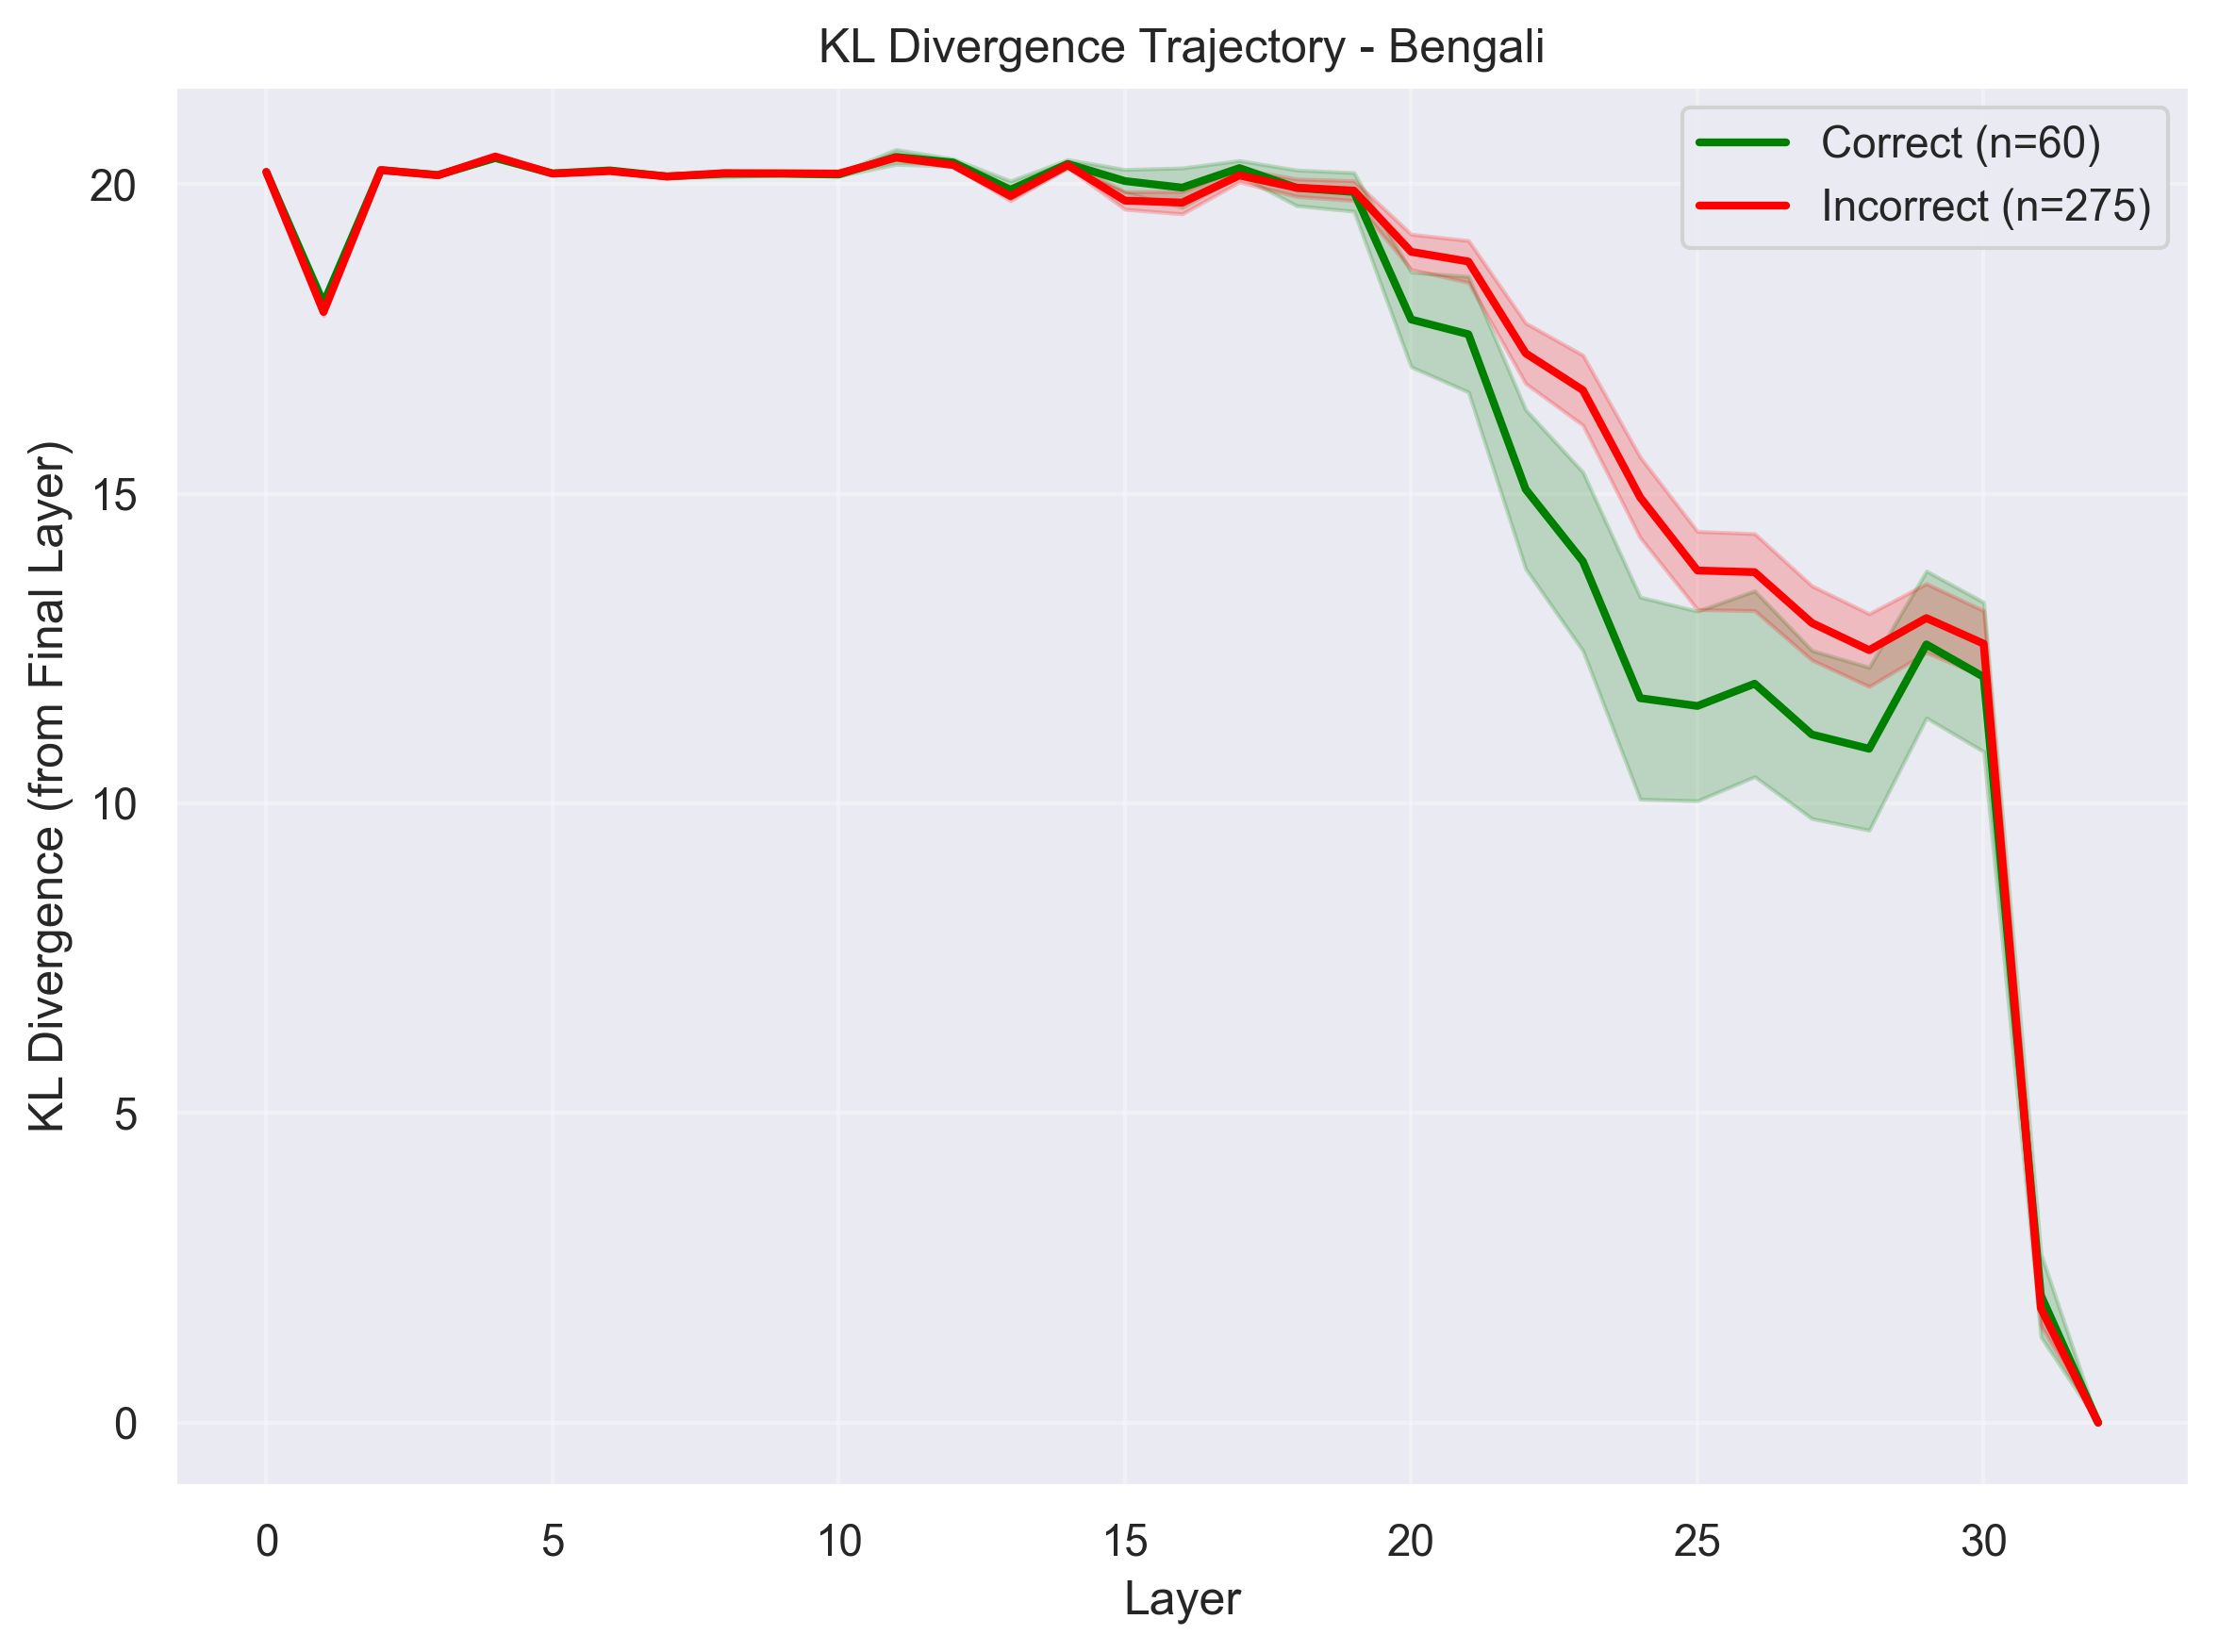

Processing english...
Saved plot: figures/kl_divergence_trajectory_english.pdf


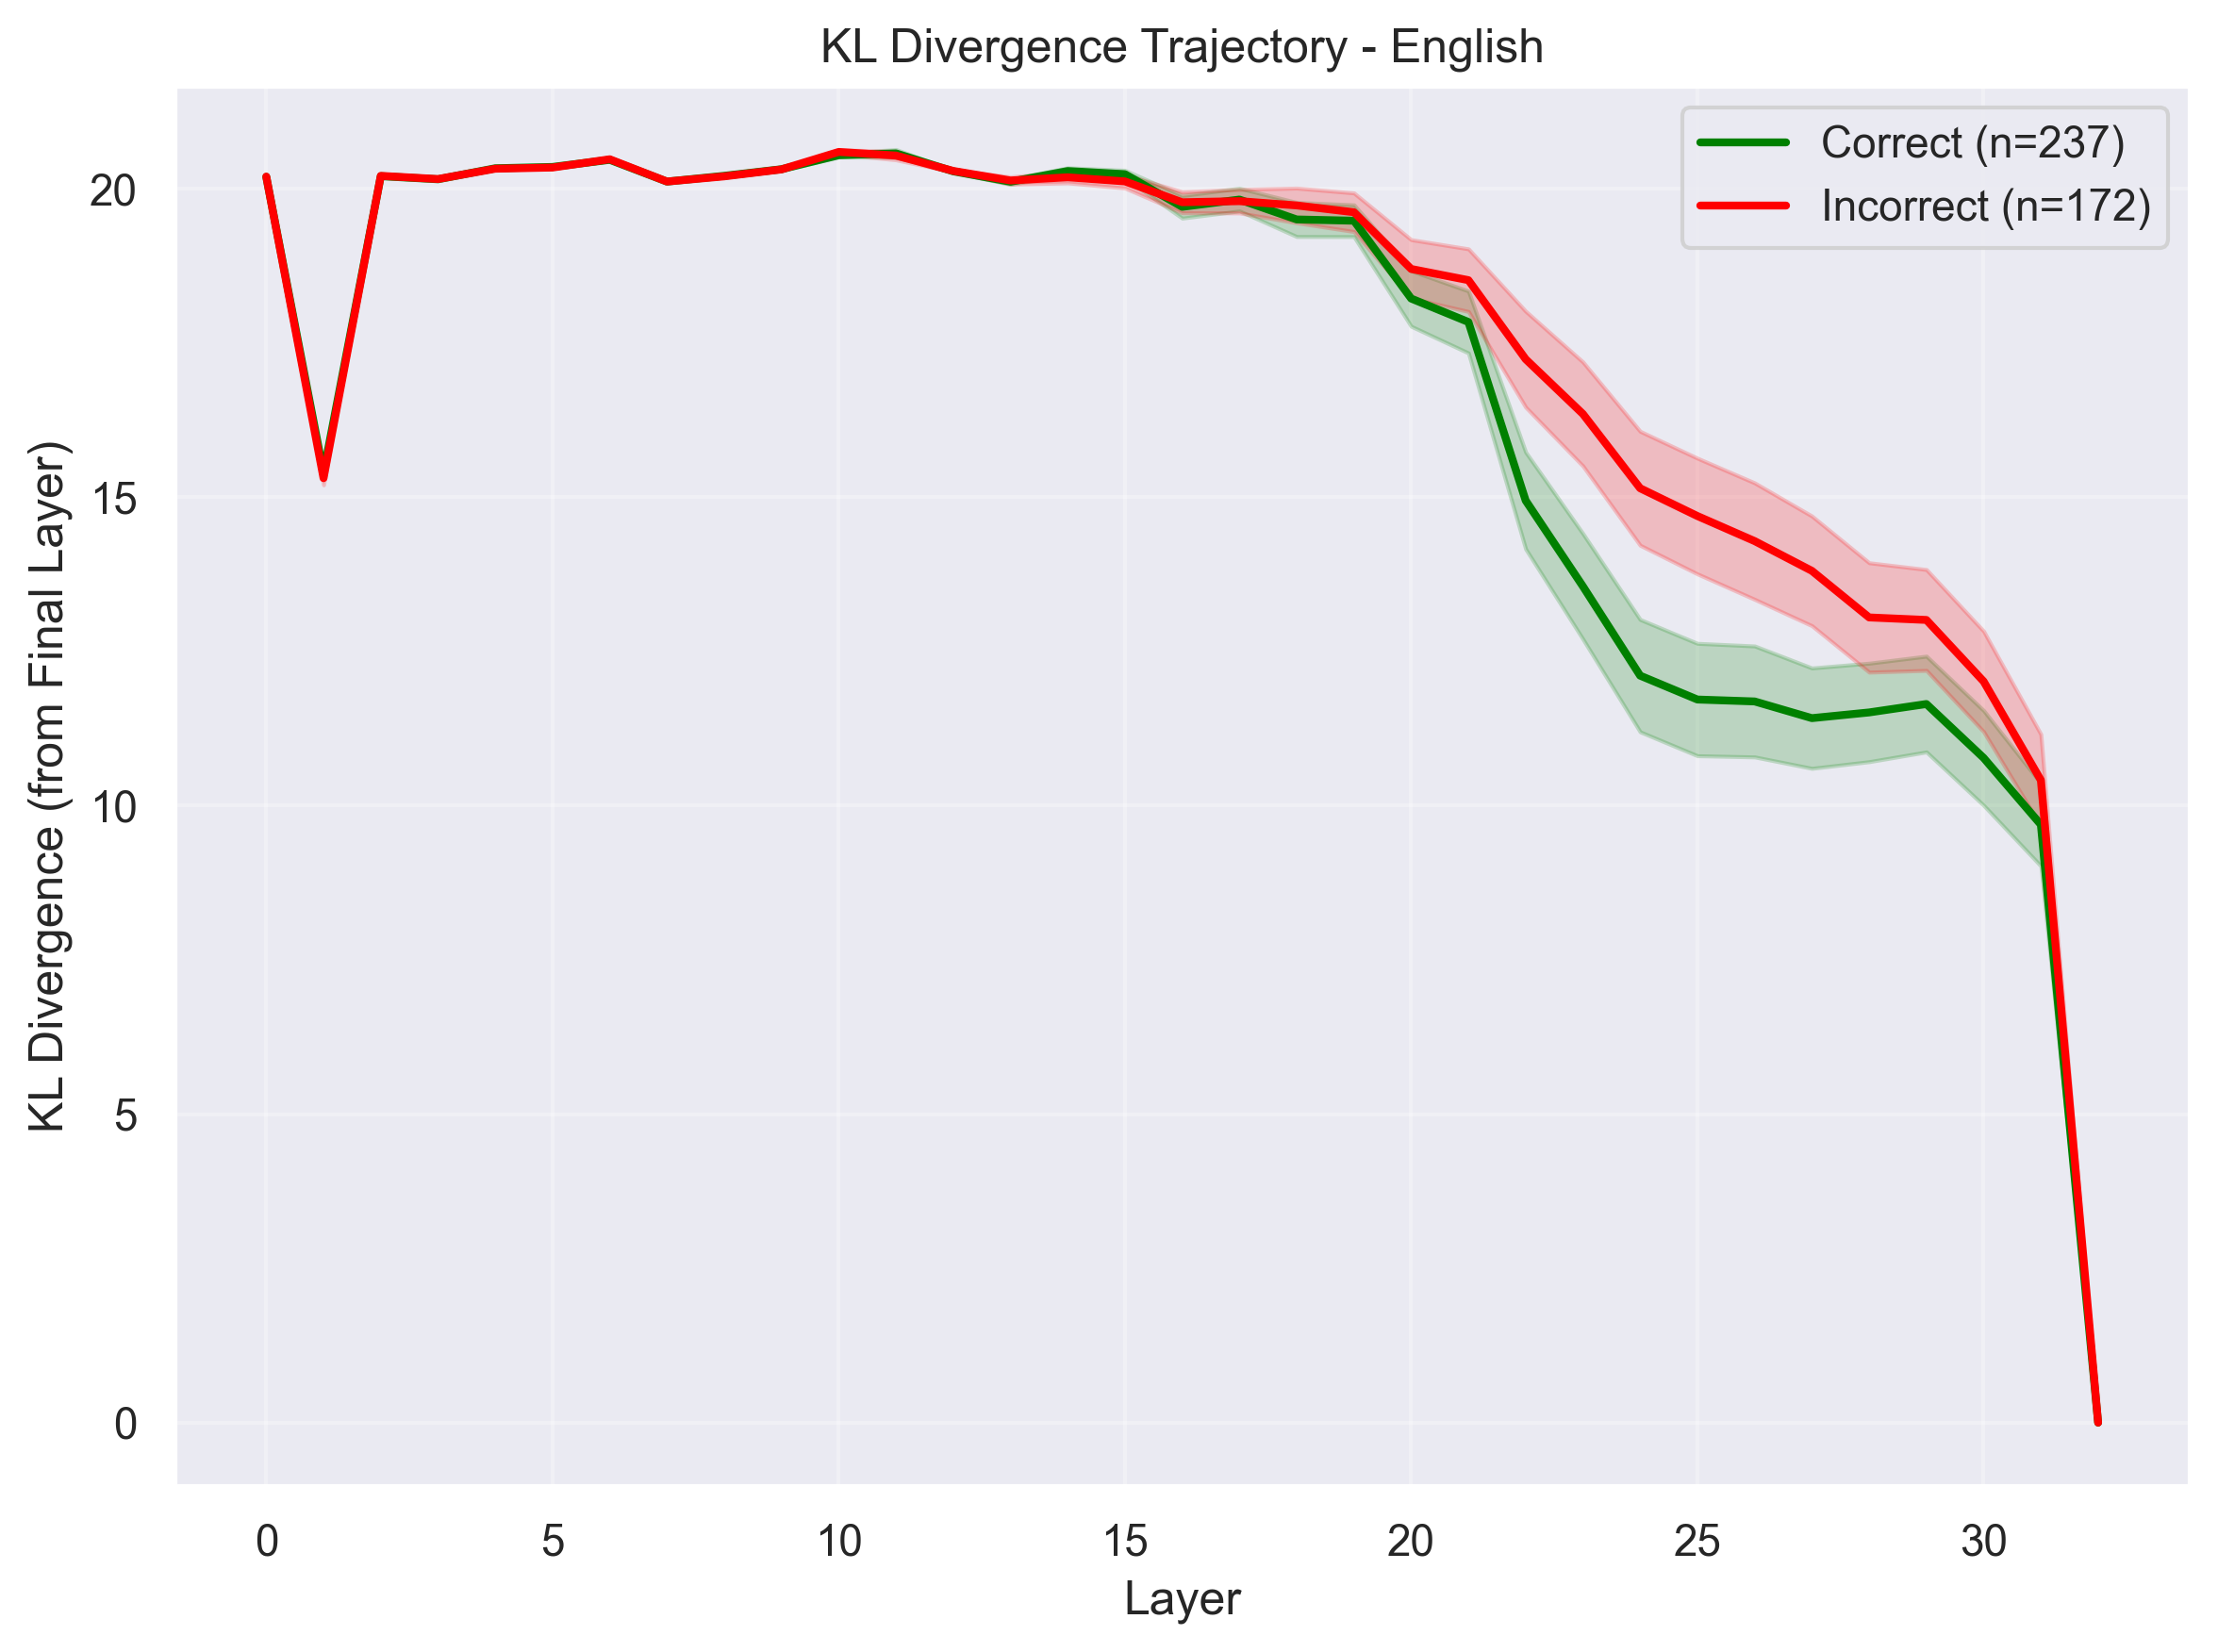

Processing spanish...
Saved plot: figures/kl_divergence_trajectory_spanish.pdf


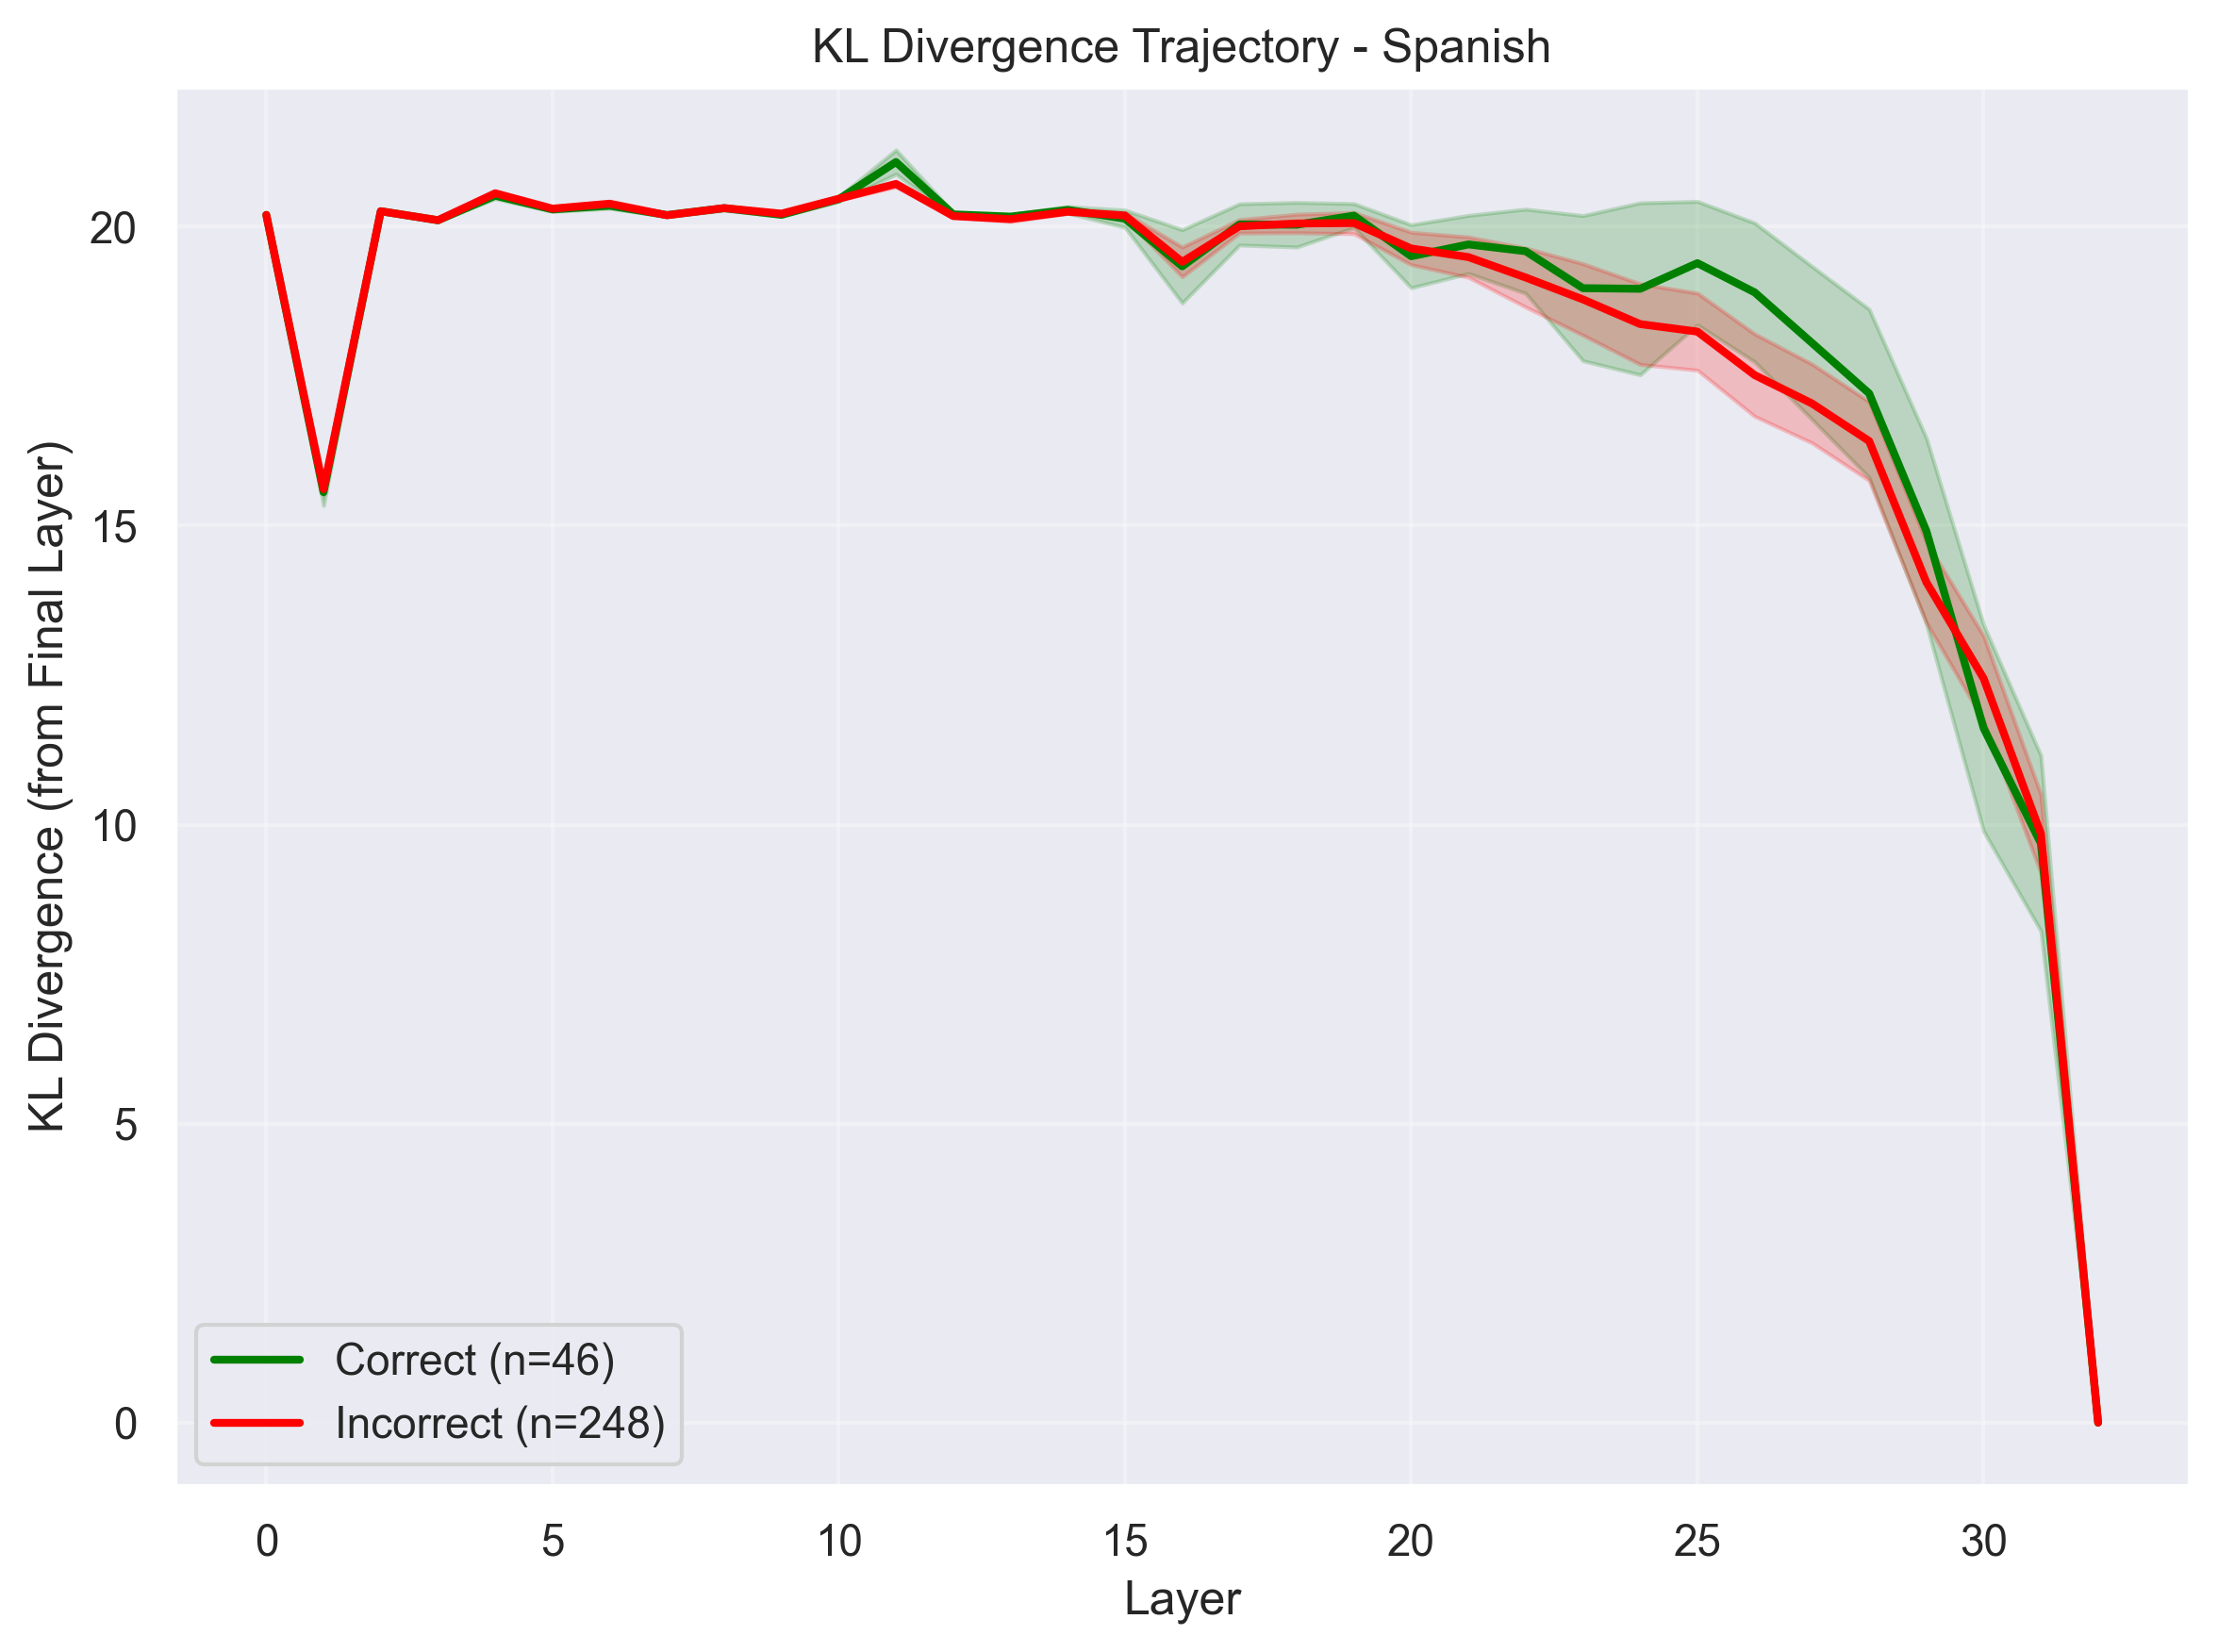

Processing assamese...
Saved plot: figures/kl_divergence_trajectory_assamese.pdf


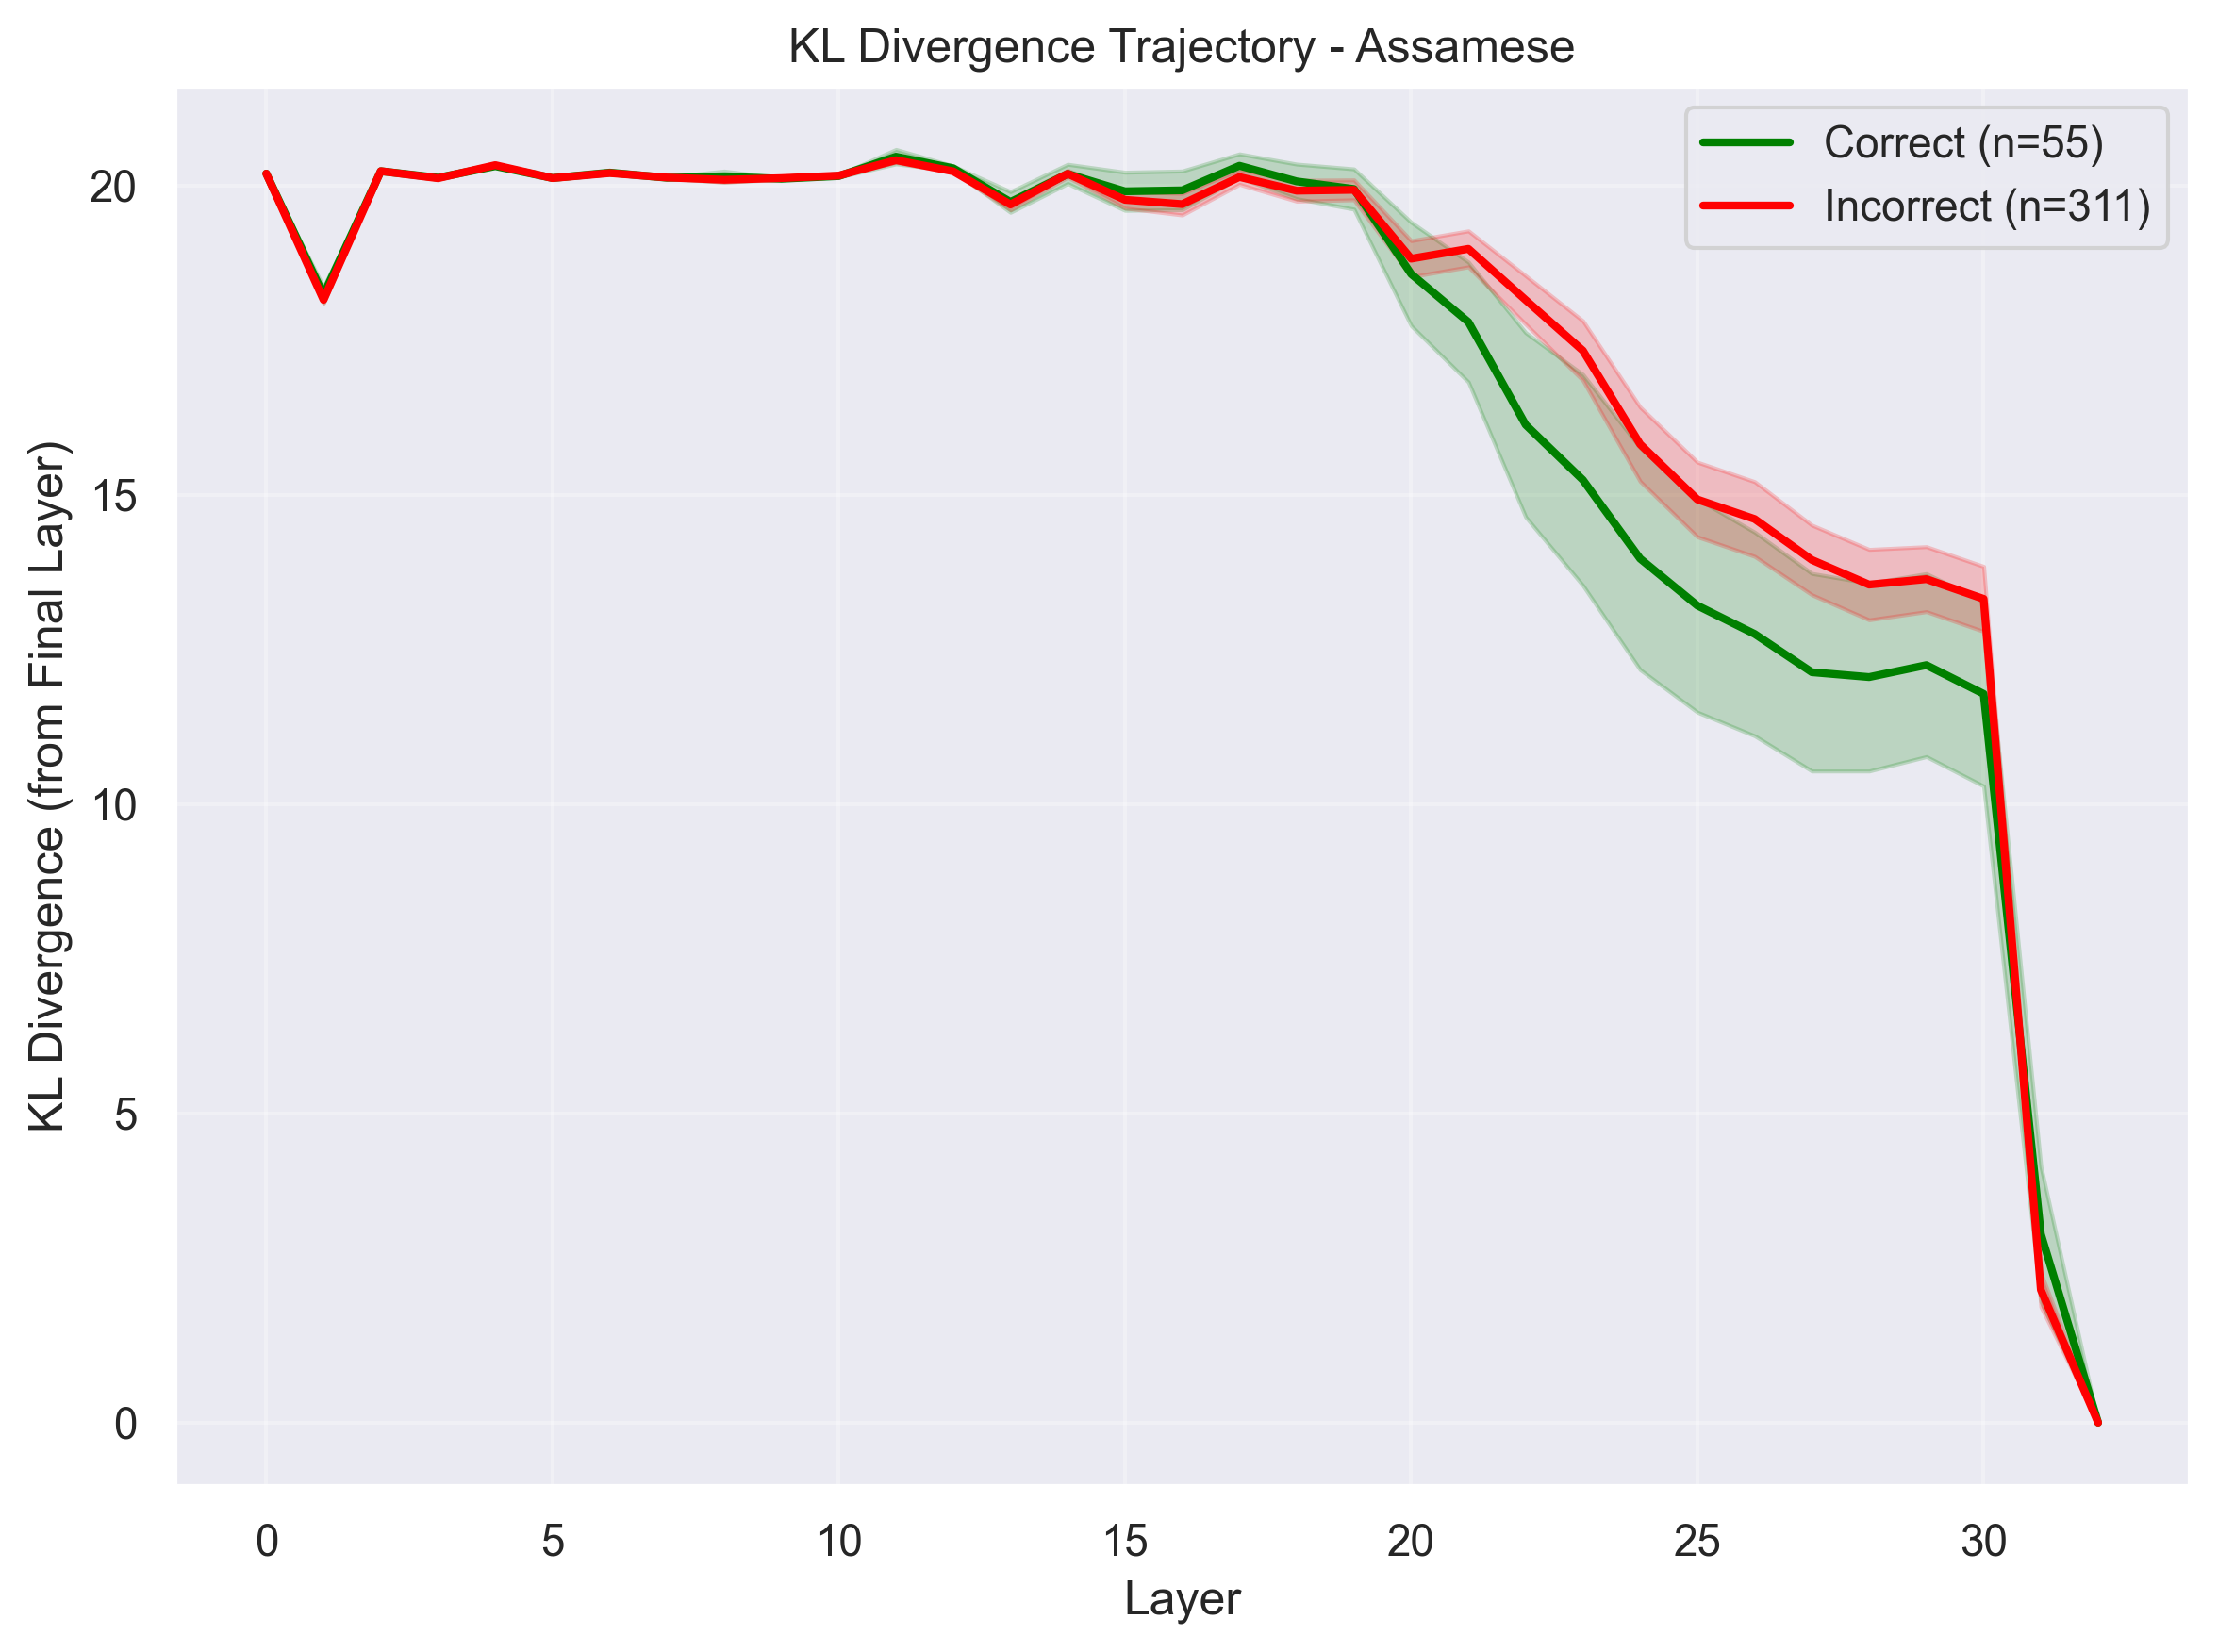

In [ ]:
def get_layer_distribution(layer_data: Dict, top_k: int = 20) -> Dict[int, float]:
    """
    Extract probability distribution from a layer as a dictionary.
    Returns: {token_id: probability}
    """
    predictions = layer_data.get("predictions", [])
    distribution = {}
    
    for pred in predictions[:top_k]:
        token_id = pred.get("token_id")
        prob = pred.get("confidence", 0.0)
        if token_id is not None and prob > 0:
            distribution[token_id] = prob
    
    # Normalize to ensure it sums to 1
    total = sum(distribution.values())
    if total > 0:
        distribution = {k: v/total for k, v in distribution.items()}
    
    return distribution


def compute_kl_divergence(p_dist: Dict[int, float], q_dist: Dict[int, float]) -> float:
    """
    Compute KL(P || Q) where P and Q are distributions over token_ids.
    KL(P||Q) = sum_i P(i) * log(P(i) / Q(i))
    """
    if not p_dist or not q_dist:
        return np.nan
    
    # Get union of all tokens
    all_tokens = set(p_dist.keys()) | set(q_dist.keys())
    
    kl = 0.0
    epsilon = 1e-10  # Small value to avoid log(0)
    
    for token_id in all_tokens:
        p = p_dist.get(token_id, epsilon)
        q = q_dist.get(token_id, epsilon)
        
        if p > epsilon:  # Only sum when P(token) is non-zero
            kl += p * np.log(p / q)
    
    return kl


def compute_kl_trajectory(logit_lens_data: List[Dict]) -> np.ndarray:
    """
    Compute KL divergence between each layer and the final layer.
    Returns array of KL divergences for layers 0 to L-1.
    """
    if not logit_lens_data or len(logit_lens_data) == 0:
        return np.array([])
    
    # Get final layer distribution
    final_layer = logit_lens_data[-1]
    final_dist = get_layer_distribution(final_layer)
    
    kl_trajectory = []
    
    # Compute KL for each layer vs final layer
    for layer_data in logit_lens_data[:-1]:  # Exclude final layer
        layer_dist = get_layer_distribution(layer_data)
        kl = compute_kl_divergence(layer_dist, final_dist)
        kl_trajectory.append(kl)
    
    # Add 0 for final layer (KL with itself)
    kl_trajectory.append(0.0)
    
    return np.array(kl_trajectory)


def collect_kl_trajectories_by_state(df_classified: pd.DataFrame, df_lens: pd.DataFrame) -> Dict[str, List[np.ndarray]]:
    """Collect KL divergence trajectories grouped by answer state."""
    trajectories = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        # Skip UNDETERMINED
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Get KL trajectory
        kl_traj = compute_kl_trajectory(logit_lens)
        
        if len(kl_traj) > 0 and not np.any(np.isnan(kl_traj)):
            trajectories[state].append(kl_traj)
    
    return trajectories


def plot_kl_divergence_trajectories(language: str, df_classified: pd.DataFrame):
    """Plot KL divergence trajectories for correct vs incorrect answers."""
    df_lens = load_lens_data(language)
    
    # Collect KL trajectories
    trajectories = collect_kl_trajectories_by_state(df_classified, df_lens)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {State.CORRECT: "green", State.INCORRECT: "red"}
    labels = {State.CORRECT: "Correct", State.INCORRECT: "Incorrect"}
    
    for state in [State.CORRECT, State.INCORRECT]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        # Plot mean
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        # Plot confidence interval
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("KL Divergence (from Final Layer)")
    ax.set_title(f"KL Divergence Trajectory - {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/kl_divergence_trajectory_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


# Run analysis for all languages
print("Plotting KL divergence trajectories...\n")

for lang in LANGUAGES:
    print(f"Processing {lang}...")
    df_classified = modified_dfs[lang]
    plot_kl_divergence_trajectories(lang, df_classified)

In [ ]:
def analyze_layer1_kl_dip(df_classified: pd.DataFrame, df_lens: pd.DataFrame, language: str):
    """Analyze cases where layer 1 KL is lower than layers 0 and 2"""
    
    dip_cases = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens or len(logit_lens) < 3:
            continue
        
        kl_traj = compute_kl_trajectory(logit_lens)
        
        if len(kl_traj) < 3 or np.any(np.isnan(kl_traj)):
            continue
        
        # Check if layer 1 has a dip (lower than both layer 0 and layer 2)
        if kl_traj[1] < kl_traj[0] and kl_traj[1] < kl_traj[2]:
            # Get distributions
            layer0_dist = get_layer_distribution(logit_lens[0])
            layer1_dist = get_layer_distribution(logit_lens[1])
            layer2_dist = get_layer_distribution(logit_lens[2])
            final_dist = get_layer_distribution(logit_lens[-1])
            
            # Find tokens that increase in layer 1 (closer to final)
            tokens_increased = []
            for token_id in final_dist.keys():
                prob_l0 = layer0_dist.get(token_id, 0.0)
                prob_l1 = layer1_dist.get(token_id, 0.0)
                prob_l2 = layer2_dist.get(token_id, 0.0)
                prob_final = final_dist.get(token_id, 0.0)
                
                # If layer 1 is closer to final than layer 0
                if prob_l1 > prob_l0 and abs(prob_l1 - prob_final) < abs(prob_l0 - prob_final):
                    # Get token string
                    token_str = None
                    for pred in logit_lens[1]["predictions"]:
                        if pred.get("token_id") == token_id:
                            token_str = pred.get("token", "")
                            break
                    
                    tokens_increased.append({
                        'token_id': token_id,
                        'token': token_str,
                        'prob_l0': prob_l0,
                        'prob_l1': prob_l1,
                        'prob_l2': prob_l2,
                        'prob_final': prob_final,
                        'increase_l0_to_l1': prob_l1 - prob_l0
                    })
            
            # Sort by increase magnitude
            tokens_increased.sort(key=lambda x: x['increase_l0_to_l1'], reverse=True)
            
            dip_cases[state].append({
                'idx': idx,
                'kl_l0': kl_traj[0],
                'kl_l1': kl_traj[1],
                'kl_l2': kl_traj[2],
                'dip_magnitude': (kl_traj[0] - kl_traj[1]) + (kl_traj[2] - kl_traj[1]),
                'tokens_increased': tokens_increased[:10]  # Top 10
            })
    
    # Print analysis
    print(f"\n=== Layer 1 KL Dip Analysis for {language.capitalize()} ===")
    for state in [State.CORRECT, State.INCORRECT]:
        cases = dip_cases[state]
        if cases:
            print(f"\n{state.upper()}: {len(cases)} cases with layer 1 dip")
            # Sort by dip magnitude
            sorted_cases = sorted(cases, key=lambda x: x['dip_magnitude'], reverse=True)[:5]
            
            for i, case in enumerate(sorted_cases, 1):
                print(f"\n  Case {i} - Idx {case['idx']}:")
                print(f"    KL Layer 0: {case['kl_l0']:.4f}")
                print(f"    KL Layer 1: {case['kl_l1']:.4f} (DIP)")
                print(f"    KL Layer 2: {case['kl_l2']:.4f}")
                print(f"    Dip Magnitude: {case['dip_magnitude']:.4f}")
                
                print(f"\n    Tokens that moved toward final distribution in layer 1:")
                for tok_info in case['tokens_increased'][:5]:
                    if tok_info['token']:
                        print(f"      '{tok_info['token']}' (id={tok_info['token_id']})")
                        print(f"        L0: {tok_info['prob_l0']:.4f} -> L1: {tok_info['prob_l1']:.4f} -> L2: {tok_info['prob_l2']:.4f} -> Final: {tok_info['prob_final']:.4f}")
                        print(f"        Increase: +{tok_info['increase_l0_to_l1']:.4f}")
    
    return dip_cases


# Run analysis
print("\nAnalyzing layer 1 KL dips...\n")

for lang in LANGUAGES:
    df_classified = modified_dfs[lang]
    df_lens = load_lens_data(lang)
    dip_analysis = analyze_layer1_kl_dip(df_classified, df_lens, lang)


Analyzing layer 1 KL dips...


=== Layer 1 KL Dip Analysis for Bengali ===

CORRECT: 60 cases with layer 1 dip

  Case 1 - Idx Na-ko-30:
    KL Layer 0: 20.1961
    KL Layer 1: 16.9693 (DIP)
    KL Layer 2: 20.2113
    Dip Magnitude: 6.4688

    Tokens that moved toward final distribution in layer 1:

  Case 2 - Idx Na-ko-44:
    KL Layer 0: 20.1961
    KL Layer 1: 17.0669 (DIP)
    KL Layer 2: 20.2269
    Dip Magnitude: 6.2891

    Tokens that moved toward final distribution in layer 1:
      ' ' (id=220)
        L0: 0.0000 -> L1: 0.1461 -> L2: 0.0000 -> Final: 0.4097
        Increase: +0.1461

  Case 3 - Idx An-ar-36:
    KL Layer 0: 20.1961
    KL Layer 1: 17.3148 (DIP)
    KL Layer 2: 20.1836
    Dip Magnitude: 5.7499

    Tokens that moved toward final distribution in layer 1:

  Case 4 - Idx Ne-ar-16:
    KL Layer 0: 20.1961
    KL Layer 1: 17.3832 (DIP)
    KL Layer 2: 20.2366
    Dip Magnitude: 5.6662

    Tokens that moved toward final distribution in layer 1:

  Case 5 - Idx

Layer 1 in transformers often acts as a "format layer" that makes quick decisions about structural tokens (spaces, punctuation, brackets) before deeper semantic processing happens in later layers. In early layers, attention patterns are heavily influenced by positional encodings and token-type patterns. Spaces/brackets have very predictable patterns, so layer 1 can "confidently" assign them high probability early. That's why we are noticing this dip -- maybe

# Shannon Entropy

Plotting entropy trajectories...

Processing bengali...
Saved plot: figures/entropy_trajectory_bengali.pdf


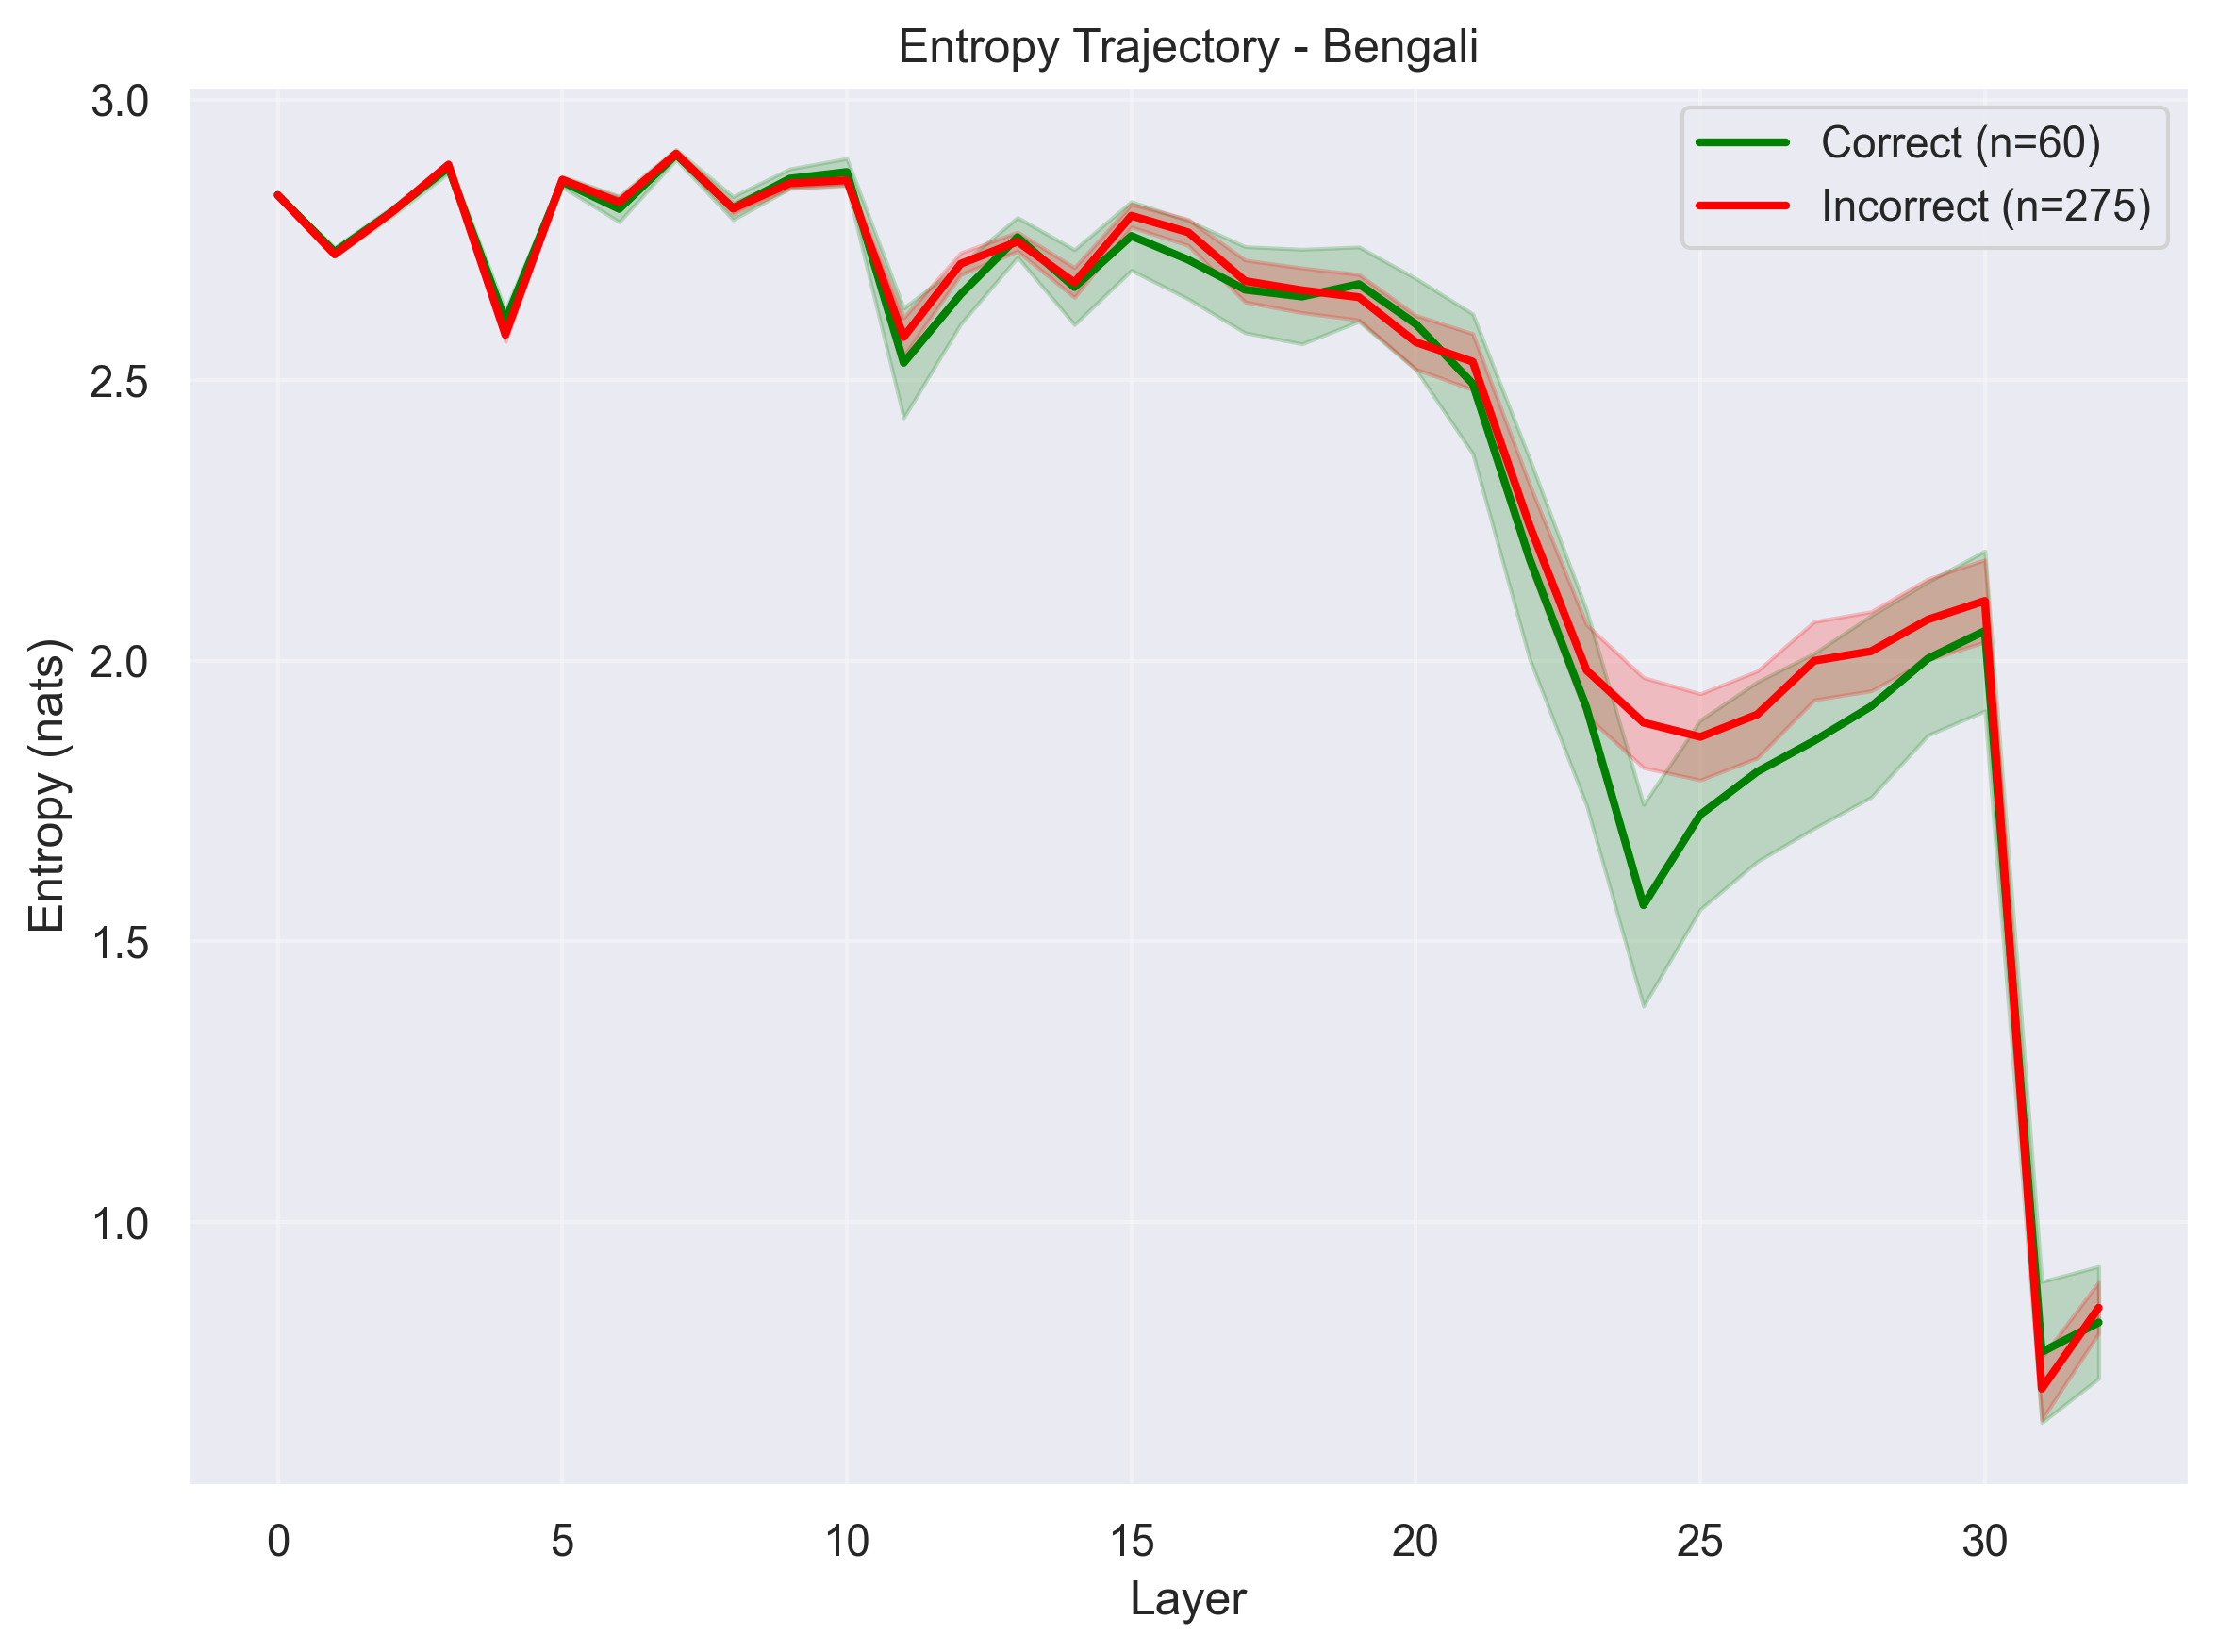

Processing english...
Saved plot: figures/entropy_trajectory_english.pdf


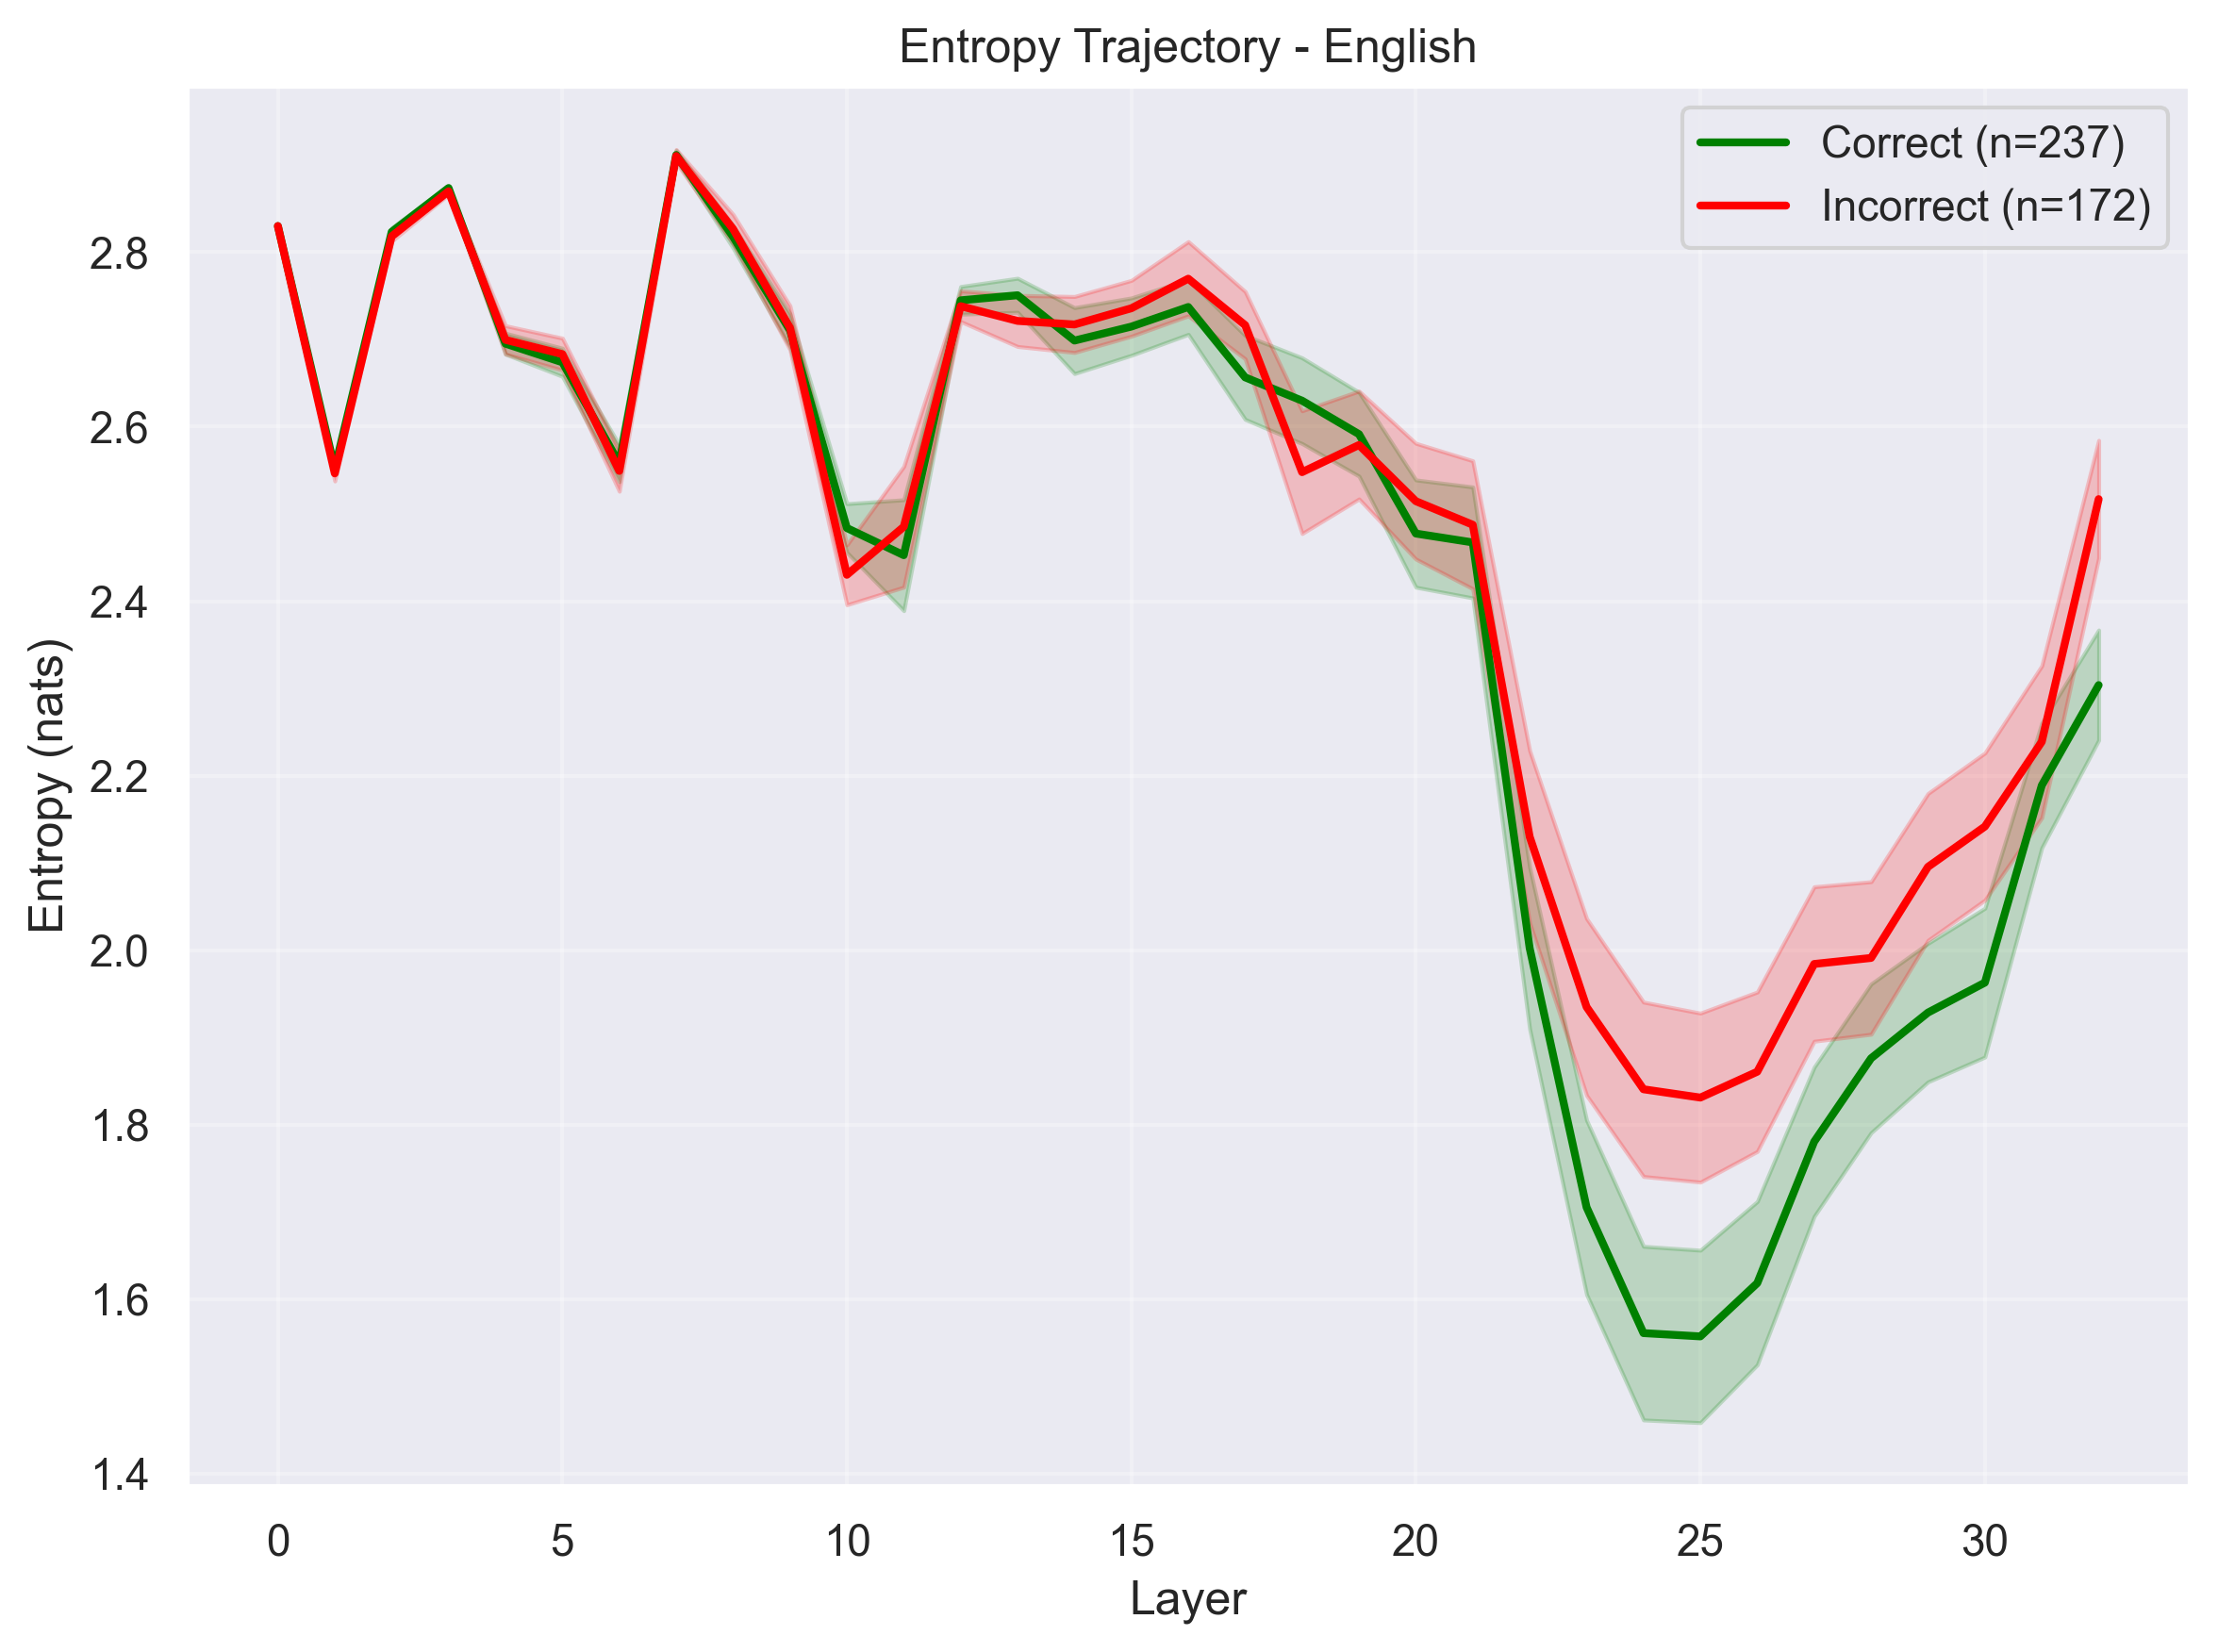

Processing spanish...
Saved plot: figures/entropy_trajectory_spanish.pdf


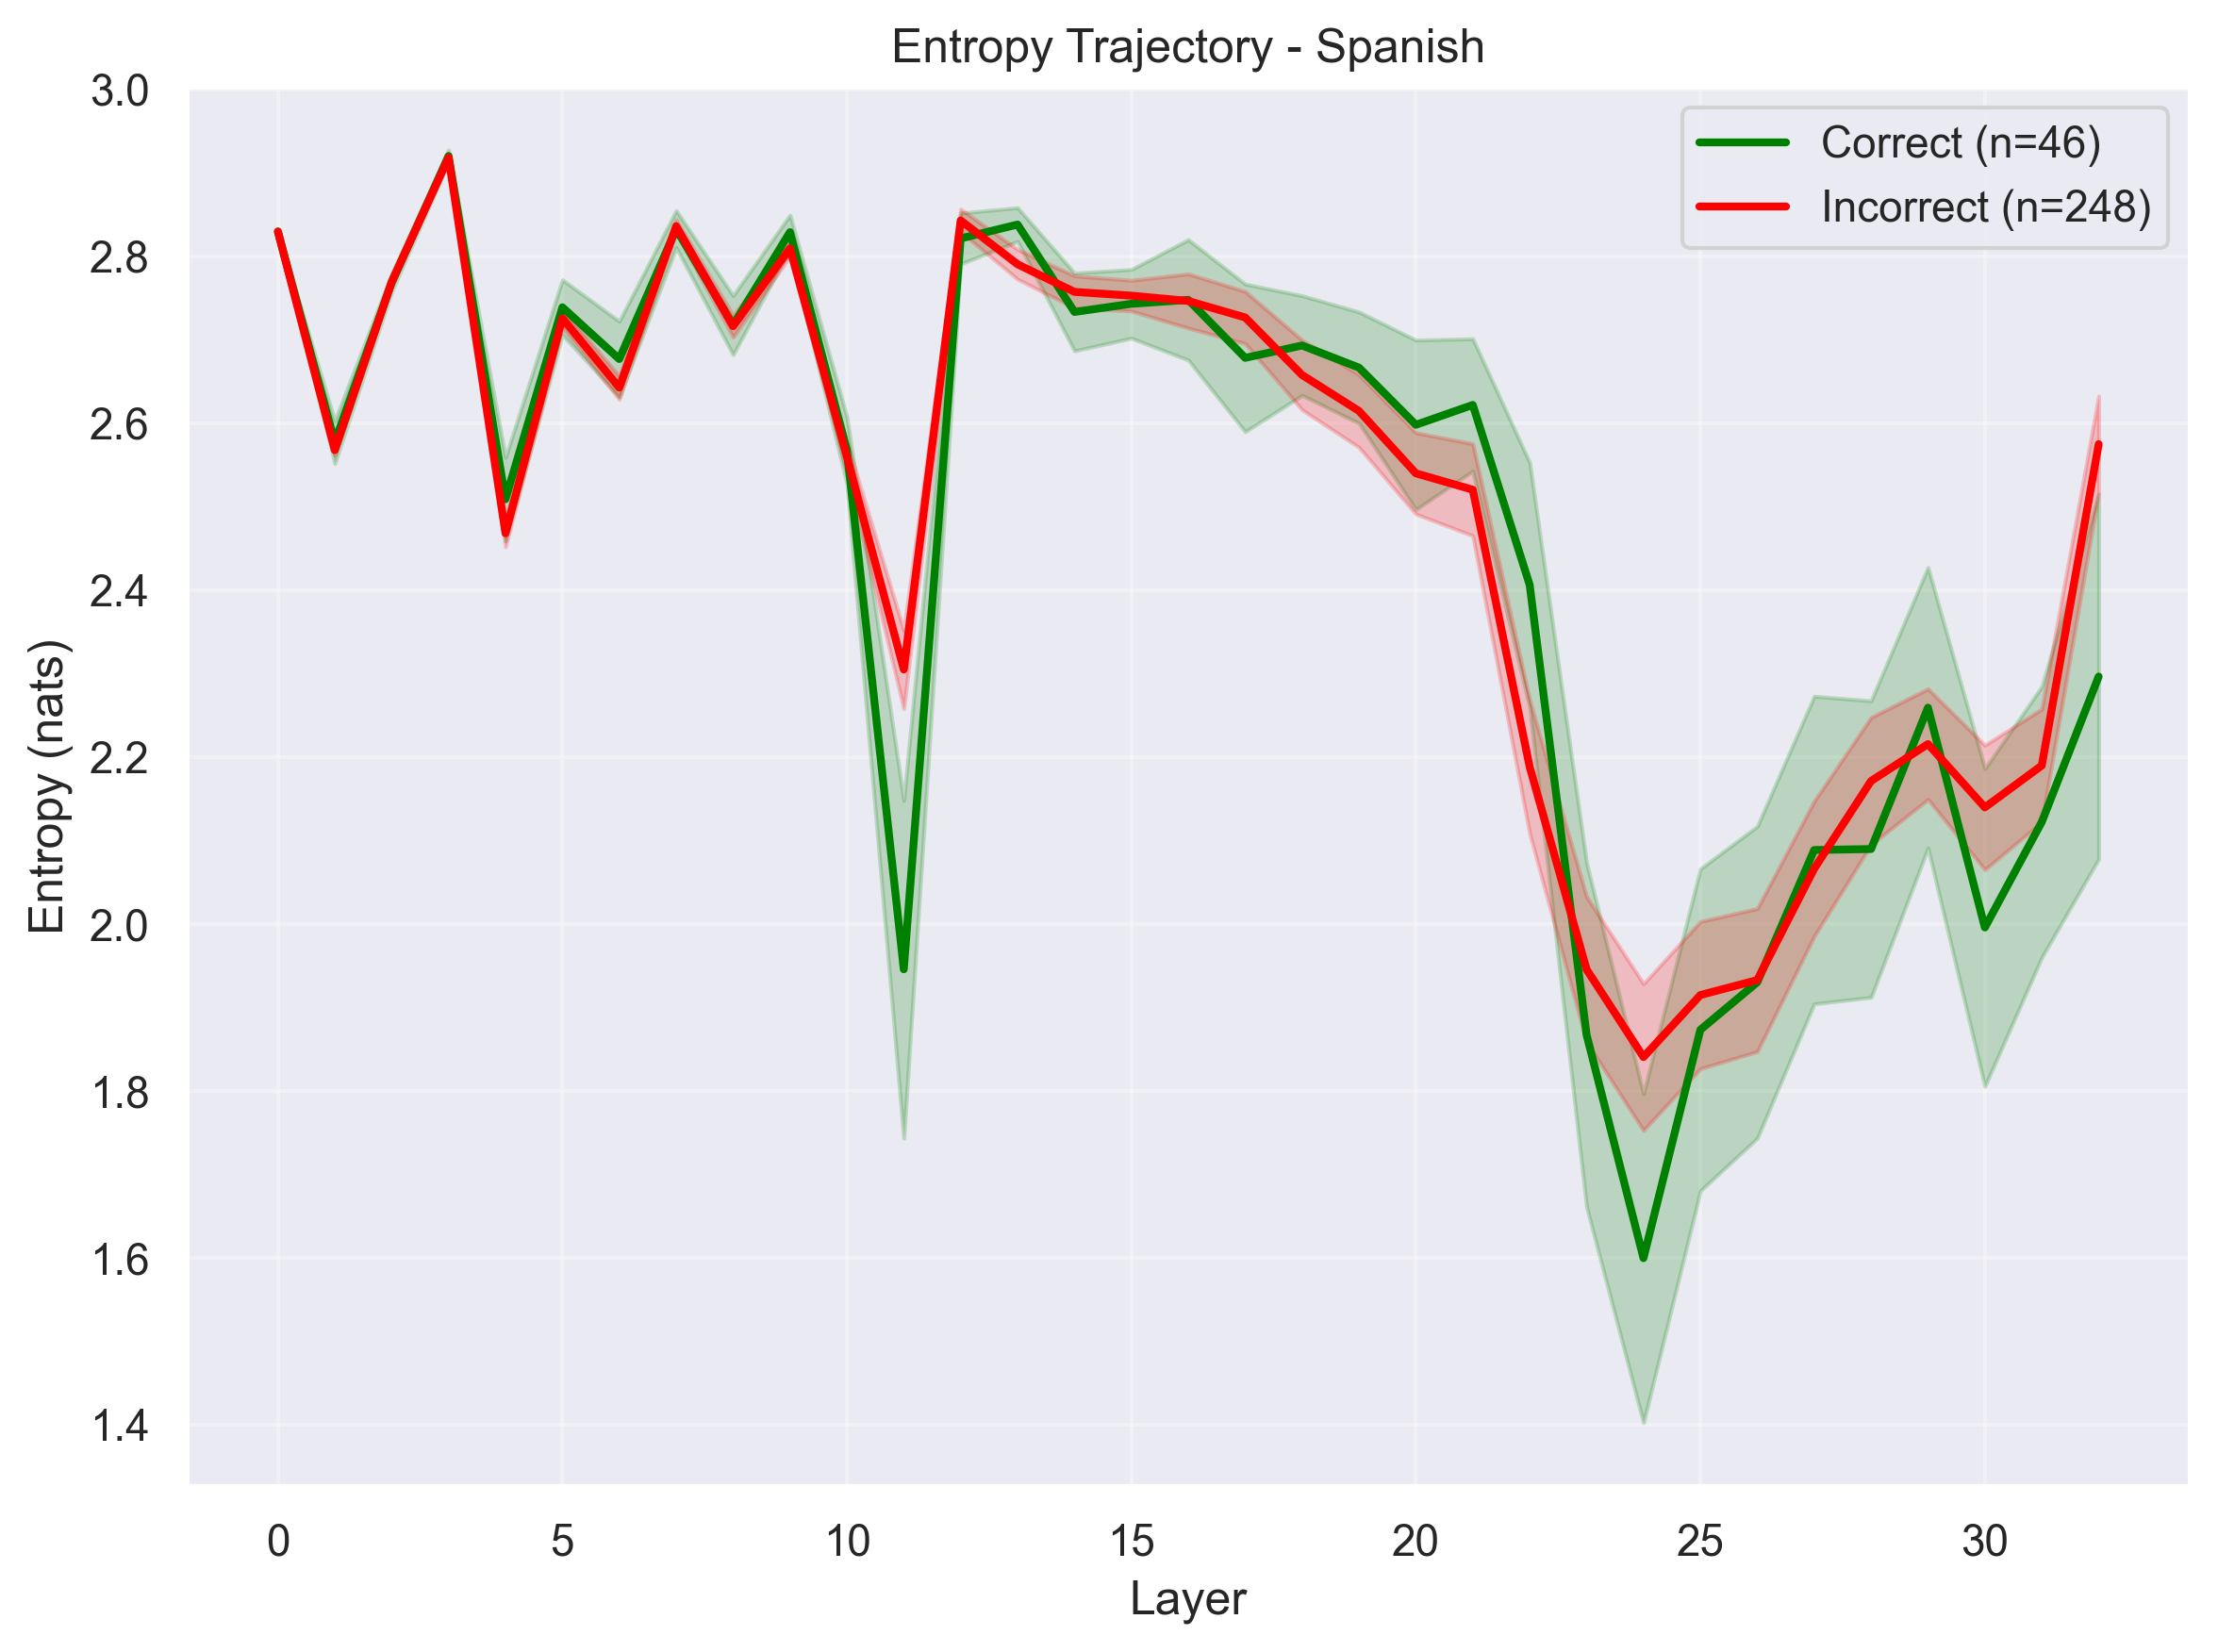

Processing assamese...
Saved plot: figures/entropy_trajectory_assamese.pdf


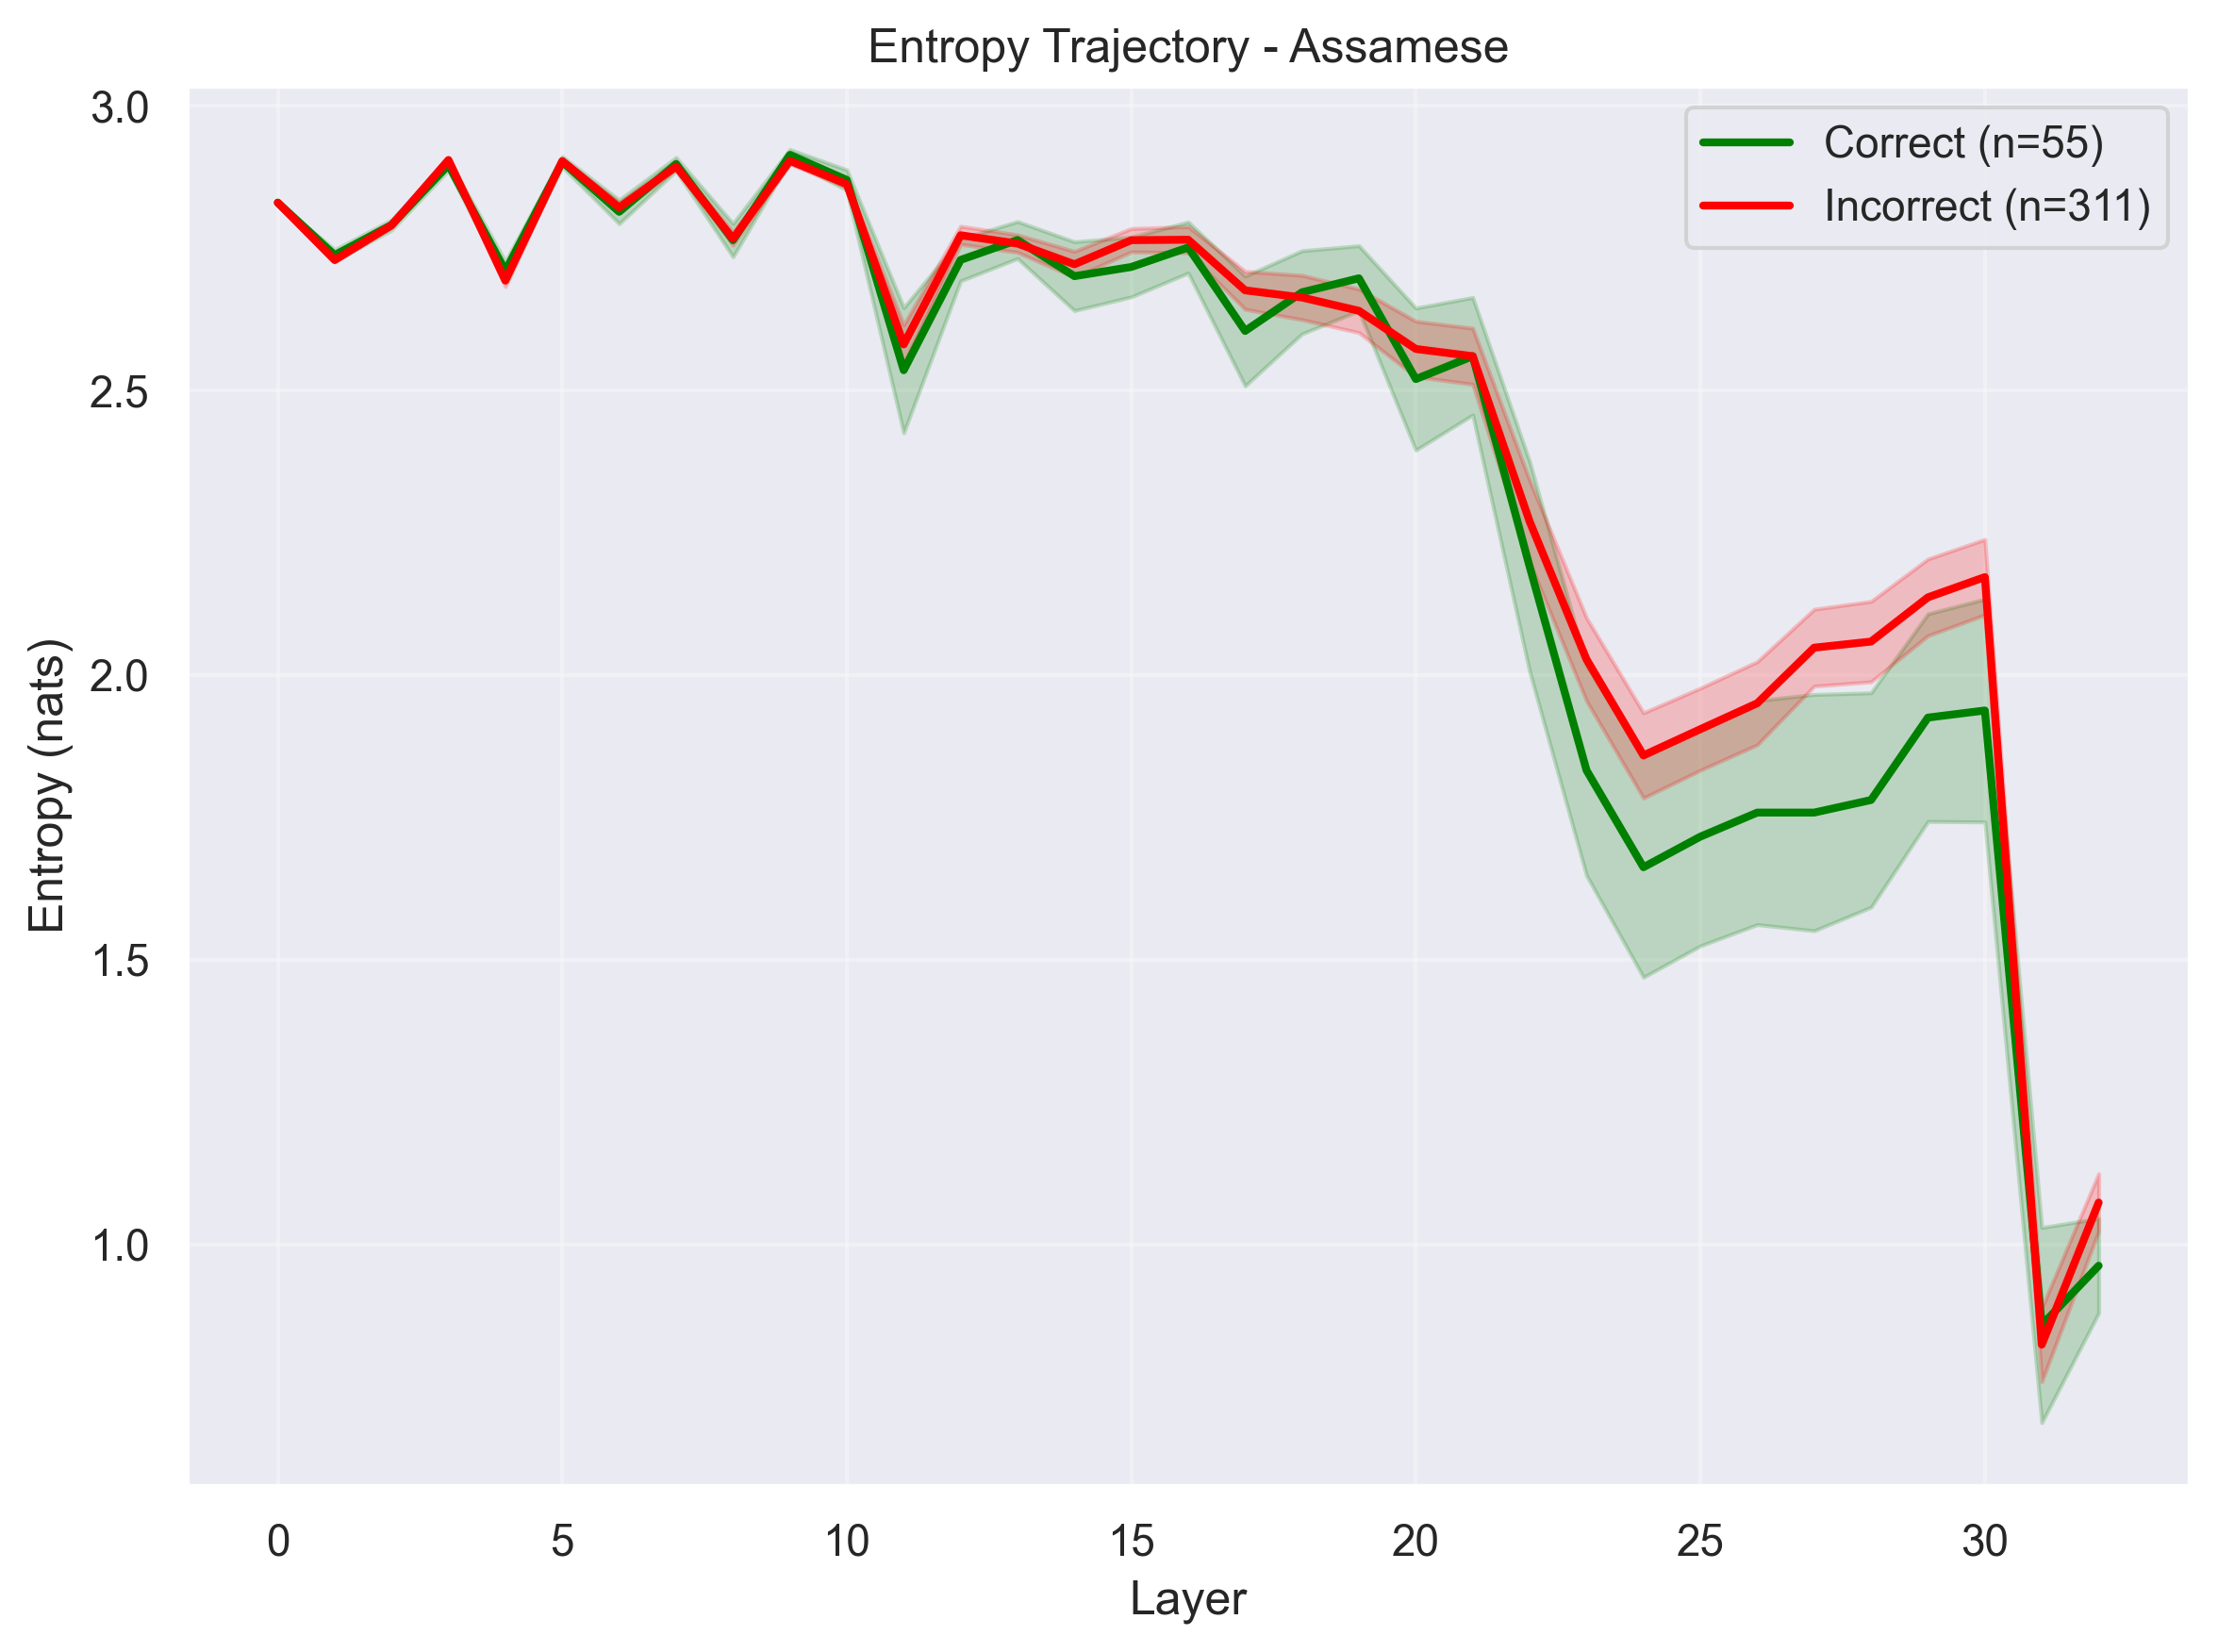

In [ ]:
def compute_entropy(distribution: Dict[int, float]) -> float:
    """
    Compute Shannon entropy of a probability distribution.
    H(P) = -sum_i P(i) * log(P(i))
    """
    if not distribution:
        return np.nan
    
    entropy = 0.0
    epsilon = 1e-10
    
    for token_id, prob in distribution.items():
        if prob > epsilon:
            entropy -= prob * np.log(prob)
    
    return entropy


def compute_entropy_trajectory(logit_lens_data: List[Dict]) -> np.ndarray:
    """
    Compute entropy at each layer.
    Returns array of entropies for all layers.
    """
    if not logit_lens_data or len(logit_lens_data) == 0:
        return np.array([])
    
    entropy_trajectory = []
    
    for layer_data in logit_lens_data:
        layer_dist = get_layer_distribution(layer_data)
        entropy = compute_entropy(layer_dist)
        entropy_trajectory.append(entropy)
    
    return np.array(entropy_trajectory)


def collect_entropy_trajectories_by_state(df_classified: pd.DataFrame, df_lens: pd.DataFrame) -> Dict[str, List[np.ndarray]]:
    """Collect entropy trajectories grouped by answer state."""
    trajectories = {State.CORRECT: [], State.INCORRECT: []}
    
    for idx in df_classified.index:
        state = df_classified.loc[idx, "State"]
        
        # Skip UNDETERMINED
        if state == State.UNDETERMINED:
            continue
        
        if idx not in df_lens.index:
            continue
        
        lens_data = df_lens.loc[idx, "Lens"]
        logit_lens = lens_data.get("LogitLens", [])
        
        if not logit_lens:
            continue
        
        # Get entropy trajectory
        entropy_traj = compute_entropy_trajectory(logit_lens)
        
        if len(entropy_traj) > 0 and not np.any(np.isnan(entropy_traj)):
            trajectories[state].append(entropy_traj)
    
    return trajectories


def plot_entropy_trajectories(language: str, df_classified: pd.DataFrame):
    """Plot entropy trajectories for correct vs incorrect answers."""
    df_lens = load_lens_data(language)
    
    # Collect entropy trajectories
    trajectories = collect_entropy_trajectories_by_state(df_classified, df_lens)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    colors = {State.CORRECT: "green", State.INCORRECT: "red"}
    labels = {State.CORRECT: "Correct", State.INCORRECT: "Incorrect"}
    
    for state in [State.CORRECT, State.INCORRECT]:
        if not trajectories[state]:
            continue
        
        mean, lower, upper = compute_trajectory_statistics(trajectories[state])
        
        if len(mean) == 0:
            continue
        
        layers = np.arange(len(mean))
        
        # Plot mean
        ax.plot(layers, mean, label=f"{labels[state]} (n={len(trajectories[state])})", 
                color=colors[state], linewidth=2)
        
        # Plot confidence interval
        ax.fill_between(layers, lower, upper, alpha=0.2, color=colors[state])
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Entropy (nats)")
    ax.set_title(f"Entropy Trajectory - {language.capitalize()}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if SAVE_PLOTS:
        filename = f"{OUTPUT_FOLDER}/entropy_trajectory_{language}.{PLOT_FORMAT}"
        plt.savefig(filename, dpi=FIGURE_DPI, bbox_inches="tight")
        print(f"Saved plot: {filename}")
    
    plt.show()


# Run analysis for all languages
print("Plotting entropy trajectories...\n")

for lang in LANGUAGES:
    print(f"Processing {lang}...")
    df_classified = modified_dfs[lang]
    plot_entropy_trajectories(lang, df_classified)